In [1]:
"""Create parameters.py and load it"""

# Directory for .inp file:
path = 'Bubble_dynamics_simulation/INP file examples/chem_Otomo2018_without_O.inp'

# import libraries:
import importlib   # For reloading your own files
from termcolor import colored   # for colored error messages
# my own files:
try:
    import inp_data_extractor as inp
except:
    try:
        import Bubble_dynamics_simulation.inp_data_extractor as inp
    except:
        print(colored(f'Error, \'inp_data_extractor.py\' not found', 'red'))
importlib.reload(inp)   # reload changes you made
inp.extract(path)

import parameters as par   # numeric constants and coefficents
importlib.reload(par)   # reload changes you made
print(par.model)

path=Bubble_dynamics_simulation/INP file examples/chem_Otomo2018_without_O.inp
Note, lambda value for specie 'H' is not in data.py: 0.0 is used
Note, lambda value for specie 'NH2' is not in data.py: 0.0 is used
Note, lambda value for specie 'NH' is not in data.py: 0.0 is used
Note, lambda value for specie 'N' is not in data.py: 0.0 is used
Note, lambda value for specie 'NNH' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H4' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H3' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H2' is not in data.py: 0.0 is used
Note, lambda value for specie 'H2NN' is not in data.py: 0.0 is used
Warning, third body 'H2O' is not in species in line 64 (' H2/2.5/ H2O/12/ AR/0.0/ ') in reaction 'H2+M=H+H+M'
Warning, third body 'AR' is not in species in line 64 (' H2/2.5/ H2O/12/ AR/0.0/ ') in reaction 'H2+M=H+H+M'
model: chem_Otomo2018_without_O
File 'parameters.py' succesfully created
chem_Otomo2018_without_O


In [41]:
"""Libraries"""

# for plotting:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

import numpy as np   # matrices, math
import time   # runtime measurement
import random   # random number generator
from multiprocessing import Pool, cpu_count   # multithreading
import importlib   # reload changes you made
import json   # convert dictionary to string

# my own file:
already_imported = 'gm' in globals()
try:
    import gradient_method as gm
except:
    try:
        import Bubble_dynamics_simulation.gradient_method as gm
    except:
        print(colored(f'Error, \'gradient_method.py\' not found', 'red'))
if already_imported: importlib.reload(gm)   # reload changes you made

model: chem_Otomo2018_without_O
target specie: NH3
excitation: sin_impulse_logf (control parameters: ['p_A', 'logf', 'n'])
enable heat transfer: True	enable evaporation: False	enable reactions: True	enable dissipated energy: True


In [43]:
"""Control parameter ranges and division"""
# a list for each control parameter, containing all the possible values

ranges = dict(
  # Initial conditions:
    # bubble equilibrium radius [m]
    R_E = [1.0e-6*x for x in [1.0, 1000.0]], # [um --> m]
    # initial radius / equilibrium radius R_0/R_E [-]
    ratio = [1.0],
    # indexes of species in initial bubble
    gases=[[par.index['N2'], par.index['H2']]],
    # Molar fractions of species in the initial bubble (H2 and N2) [-]
    fractions=[[0.25, 0.75]],
  # Ambient parameters:
    # ambient pressure [Pa]
    P_amb = [x * par.atm2Pa for x in [1.0]], # [atm --> Pa]
    # ambient temperature [K]       
    T_inf = [par.absolute_zero + x for x in [30.0]], # [°C --> K]
  # Liquid parameters:
    # water accommodation coefficient [-]
    alfa_M = [0.35],
    #P_v = par.P_v,                    # vapour pressure [Pa]
    #mu_L = par.mu_L,                  # dynamic viscosity [Pa*s]
    # sound speed [m/s]
    c_L = [par.c_L],
    # surfactant (surface tension modfier) [-]
    surfactant = [1.0],
  # Excitation parameters: (excitation_type = no_excitation)
    p_A = [-x * par.atm2Pa for x in [3.0, 1.0]], # [atm --> Pa]
    logf = [4.0, 6.0],
    n = [1.0],
)

for key in gm.de.excitation_args:
    if key not in ranges:
        print(colored(f'Error, {key} not in ranges', 'red'))

In [44]:
to_optimize = 'energy_efficiency'   # key in data from de.get_data()
searches = 30    # number os total searches

kwargs_list = [dict(
    ranges=ranges,
    to_optimize=to_optimize,
    start_point=gm.rand_point(ranges, padding=0.1, gases=[par.index['N2'], par.index['H2']]),
    max_steps=1000,
    first_step=0.05, #between two parameter combinations
    min_step=1e-4, #between two parameter combinations
    decay=0.6,
    learning_rate=1.0,
    t_int=[0.0, 1.0],
    LSODA_timeout=30,
    Radau_timeout=300,
    ) for i in range(searches)]

In [45]:
"""Save settings as txt"""

# create folder for parameter study results:
file = gm.de.Make_dir('2_plus_1_gradient_search/1_atm_grad_method')

# save all settings (full_bubble_model.py, parameters.py, ranges) as txt:
to_print = gm.de.copy(kwargs_list[0])
del to_print['ranges']
del to_print['start_point']
ranges_str = f'''
ranges = {json.dumps(ranges, indent=4)}

settings = {json.dumps(to_print, indent=4)}

start_points = [
'''

for kwargs in kwargs_list:
    ranges_str += json.dumps(kwargs['start_point'], indent=4) + ',\n'
ranges_str += ']'

file.write_string(ranges_str, 'gradient_method_settings')

Folder already exists with 0 csv in it


In [46]:
""" Gradient method, multithread"""

best_output = 1.0e30
total_point_num = 0
num = 0
to_plot = []
last_points = []
start = time.time()

with Pool(processes=cpu_count()-6, maxtasksperchild=10) as pool:
    results = pool.imap_unordered(gm.search, kwargs_list)
    for result in results:
        datas, best_central_values, elapsed, step_num, point_num = result
        total_point_num += point_num
        num += 1
        to_plot.append(best_central_values)
        last_points.append(gm.de.copy(datas[-1]))
        for i in range(len(datas)):
            if datas[i]['output'] < best_output:
                best_output = datas[i]['output']

        # save points
        file.new_file()
        for data in datas:
            file.write_line(data)
        file.close()
        del(datas)
        
        # print stuff:
        if point_num==0: point_num=1
        print(f'{num: <3}/{searches}: Total {len(best_central_values): <3} steps and {point_num: <4} points, finished in {elapsed: 8.2f} [s]   ({(elapsed / point_num): 4.2f} [s/run]).   '+
              f'Final {to_optimize}: {last_points[-1][to_optimize]: 8.1f} (best: {best_output: 6.1f})')
            
file.close()
end = time.time()
elapsed = end - start
print(f'\n\nDONE')
print(f'total time: {((elapsed-elapsed % 3600) / 3600): .0f} hours {((elapsed % 3600) / 60): .0f} mins')
print(f'            {elapsed: .2f} [s]   ({(elapsed / total_point_num): .2f} [s/run])')

step_num=1/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.00010633352927199885, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -226433.96116211708, 'logf': 5.634285577717633, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.05, 'output': 1e+30}
current_step=0.05; step_num=1
step_num=2/1000
current_step=0.03; step_num=2
step_num=3/1000
best central point: output=2.3282360061982262e+27; best_point={'ID': 0, 'R_E': 8.517063461004213e-05, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -222129.211458692, 'logf': 5.634285577717633, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.03, 'output': 2.3282360061982262e+27}
current_step=0.03; step_num=3
step_num=4/1000
current_step=0.018; step_num=4
step_num

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=3/1000
current_step=0.010799999999999999; step_num=3
step_num=1/1000
best central point: output=1.9096436639786198e+17; best_point={'ID': 0, 'R_E': 0.0008488831826656195, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -232505.2304254081, 'logf': 5.391350533042369, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.05, 'output': 1.9096436639786198e+17}
current_step=0.05; step_num=1
step_num=4/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.000755766025991358, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -249324.99135263782, 'logf': 5.012743629475718, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.010799999999999999, 'output': 1e+30}
current_step=0.010799999999999999; step_num=4
step_num

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=6/1000


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


best central point: output=9.325368468036348e+18; best_point={'ID': 0, 'R_E': 0.0007589261095077386, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -250872.57939606992, 'logf': 5.012743629475718, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.010799999999999999, 'output': 9.325368468036348e+18}
current_step=0.010799999999999999; step_num=6
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2304351711565D-01   r2 =  0.1592301671420D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2304351711565D-01   r2 =  0.1592301671420D-17
 lsoda--  warning..internal t (=r1) a

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=4/1000
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2350197407474D-01   r2 =  0.1589533654558D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2350197407474D-01   r2 =  0.1589533654558D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2350197407474D-01   r2 =  0.1589533654558D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2350197407474D-01   r2 =  0.1589533654558D-17
 lsoda--  warning..i

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


best central point: output=1.1446788823890259e+21; best_point={'ID': 0, 'R_E': 0.0008788531826656196, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -222372.7304254081, 'logf': 5.391350533326939, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.03, 'output': 1.1446788823890259e+21}
current_step=0.03; step_num=4
step_num=10/1000
current_step=0.0013996799999999997; step_num=10
step_num=11/1000
current_step=0.0008398079999999998; step_num=11
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2206599767698D-01   r2 =  0.1642697555407D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=5/1000
best central point: output=6.1186172744587624e+16; best_point={'ID': 0, 'R_E': 0.0008788531826656274, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -216293.2304254081, 'logf': 5.3913505332769525, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.03, 'output': 6.1186172744587624e+16}
current_step=0.03; step_num=5
step_num=12/1000
current_step=0.0005038847999999999; step_num=12
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3109072311213D-01   r2 =  0.1622784945697D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3109072311213D-01   r2 =  0.1622

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=14/1000
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2174426375044D-01   r2 =  0.1551851362296D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2174426375044D-01   r2 =  0.1551851362296D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2174426375044D-01   r2 =  0.1551851362296D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2174426375044D-01   r2 =  0.1551851362296D-17
 lsoda--  warning..

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0007587517332436015, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -250907.95211871873, 'logf': 5.0123945278458, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0003023308799999999, 'output': 1e+30}
current_step=0.0003023308799999999; step_num=14
best central point: output=2.7404512545825684e+16; best_point={'ID': 0, 'R_E': 0.0008788531826656274, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -216293.2304254081, 'logf': 5.427350533276952, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.018, 'output': 2.7404512545825684e+16}
current_step=0.018; step_num=7
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t o

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=16/1000
best central point: output=1.0845556766311358e+20; best_point={'ID': 0, 'R_E': 0.0007587517332435957, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -250821.30699741485, 'logf': 5.012394527845835, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0003023308799999999, 'output': 1.0845556766311358e+20}
current_step=0.0003023308799999999; step_num=16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2286855172760D-01   r2 =  0.1695310100334D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2286855172760D-01   r2 =  0.1695310100334D-17
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=9/1000
current_step=0.006479999999999999; step_num=9


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=17/1000
step_num=10/1000
current_step=0.003887999999999999; step_num=10
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0007587517332435863, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -250882.57435024684, 'logf': 5.012394527845914, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0003023308799999999, 'output': 1e+30}
current_step=0.0003023308799999999; step_num=17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2205571452119D-01   r2 =  0.1691676012304D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2205571452119D-01   r2 =  0.169

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=18/1000
current_step=0.00018139852799999994; step_num=18


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2270504990480D-01   r2 =  0.1543163303664D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2270504990480D-01   r2 =  0.1543163303664D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2270504990480D-01   r2 =  0.1543163303664D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2270504990480D-01   r2 =  0.1543163303664D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=12/1000
current_step=0.0013996799999999997; step_num=12
step_num=21/1000
current_step=0.00010883911679999996; step_num=21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2216952469038D-01   r2 =  0.1693333046850D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2216952469038D-01   r2 =  0.1693333046850D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2216952469038D-01   r2 =  0.1693333046850D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2181228163338D-01   r2 =  0.1622799995263D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2181228163338D-01   r2 =  0.1622799995263D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2181228163338D-01   r2 =  0.1622799995263D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2181228163338D-01   r2 =  0.1622799995263D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=22/1000
current_step=6.530347007999997e-05; step_num=22
2  /30: Total 10  steps and 132  points, finished in   840.45 [s]   ( 6.37 [s/run]).   Final energy_efficiency:  694951235265027458990080.0 (best:  472913906850133248.0)
step_num=15/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0008792921980448323, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -216243.27017576608, 'logf': 5.427350533276952, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0005038847999999999, 'output': 1e+30}
current_step=0.0005038847999999999; step_num=15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2381674965969D-01   r2 =  0.1525736613673D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=1/1000
current_step=0.03; step_num=1
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2348091277779D-01   r2 =  0.1579364384217D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2348091277779D-01   r2 =  0.1579364384217D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2348091277779D-01   r2 =  0.1579364384217D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2348091277779D-01   r2 =  0.15793643

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1768115492953D-01   r2 =  0.1555645003565D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1768115492953D-01   r2 =  0.1555645003565D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1768115492953D-01   r2 =  0.1555645003565D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1768115492953D-01   r2 =  0.1555645003565D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=17/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0008789362539864149, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -216315.47444356955, 'logf': 5.428358302876952, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0005038847999999999, 'output': 1e+30}
current_step=0.0005038847999999999; step_num=17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2342230093373D-01   r2 =  0.1620647381317D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2342230093373D-01   r2 =  0.1620647381317D-17
 lsoda--  warning..internal t (=r1) and h (=r2) a

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=5/1000
current_step=0.003887999999999999; step_num=5
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3702186591944D+00   r2 =  0.2322736355629D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3702186591944D+00   r2 =  0.2322736355629D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3702186591944D+00   r2 =  0.2322736355629D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3702186591944D+00   

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0008792268810933105, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -216256.51990581938, 'logf': 5.427776466827111, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0005038847999999999, 'output': 1e+30}
current_step=0.0005038847999999999; step_num=18
step_num=6/1000
current_step=0.0023327999999999995; step_num=6
step_num=7/1000
current_step=0.0013996799999999997; step_num=7
step_num=19/1000
best central point: output=9.050840346802835e+16; best_point={'ID': 0, 'R_E': 0.0008797302620085105, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -216256.51990581938, 'logf': 5.427776466827111, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0005038847999999999, 'o

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2330775996686D-01   r2 =  0.1536987429891D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2330775996686D-01   r2 =  0.1536987429891D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2330775996686D-01   r2 =  0.1536987429891D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2330775996686D-01   r2 =  0.1536987429891D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=9/1000
current_step=0.0005038847999999999; step_num=9
step_num=20/1000
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2761404180469D-01   r2 =  0.1535104889578D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2761404180469D-01   r2 =  0.1535104889578D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2761404180469D-01   r2 =  0.1535104889578D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.27

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


best central point: output=1.263523358983178e+21; best_point={'ID': 0, 'R_E': 0.0008797302620085105, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -216358.6321605394, 'logf': 5.4277764668300925, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0005038847999999999, 'output': 1.263523358983178e+21}
current_step=0.0005038847999999999; step_num=20
step_num=11/1000
best central point: output=1.2054774612340017e+18; best_point={'ID': 0, 'R_E': 0.00072996037980543, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -207273.5203843983, 'logf': 5.413845435965844, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0003023308799999999, 'output': 1.2054774612340017e+18}
current_step=0.0003023308799999999; step_num=11
step_num=21/1000

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


best central point: output=3.2897789012190775e+21; best_point={'ID': 0, 'R_E': 0.0007301347560695674, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -207238.1476617482, 'logf': 5.4141945375957485, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0003023308799999999, 'output': 3.2897789012190775e+21}
current_step=0.0003023308799999999; step_num=12
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1834546591068D-01   r2 =  0.1539233879432D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1834546591068D-01   r2 =  0.1539233879432D-17
 lsoda--  warning..internal t (=

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0008800862060671687, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -216256.51990581938, 'logf': 5.428489067548126, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0005038847999999999, 'output': 1e+30}
current_step=0.0005038847999999999; step_num=22
step_num=23/1000


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0008797302620085109, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -216184.3156380646, 'logf': 5.428489067548126, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0005038847999999999, 'output': 1e+30}
current_step=0.0005038847999999999; step_num=23
step_num=13/1000
best central point: output=3.8563998359460434e+18; best_point={'ID': 0, 'R_E': 0.0007298327275204475, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -207238.1476617482, 'logf': 5.4141945375957485, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0003023308799999999, 'output': 3.8563998359460434e+18}
current_step=0.0003023308799999999; step_num=13
 lsoda--  warning..internal t (=r1) and h (=r2

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=25/1000
current_step=0.0003023308799999999; step_num=25
step_num=14/1000
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2260279440911D-01   r2 =  0.1581598364689D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2260279440911D-01   r2 =  0.1581598364689D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2260279440911D-01   r2 =  0.1581598364689D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=26/1000
current_step=0.00018139852799999994; step_num=26
step_num=16/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0007300462939552908, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -207176.88030898746, 'logf': 5.414622098026569, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0003023308799999999, 'output': 1e+30}
current_step=0.0003023308799999999; step_num=16
step_num=27/1000
best central point: output=5.9459078786837384e+16; best_point={'ID': 0, 'R_E': 0.0008797302620085109, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -216260.43435639289, 'logf': 5.428232531289634, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.00018139852799999994, 'output': 5.9459078786837384e+16}
current_s

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=18/1000
current_step=0.00018139852799999994; step_num=18
step_num=19/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0007299181540941738, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -207202.87384537916, 'logf': 5.414017436266569, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.00018139852799999994, 'output': 1e+30}
current_step=0.00018139852799999994; step_num=19
step_num=28/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.000879602122147784, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -216234.44081992208, 'logf': 5.428232531289634, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.00018139852799999994, 'output': 1e+30}
current_step=0.00018139852799999994; step_

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0007296853884745749, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -207198.1039425775, 'logf': 5.414226897244512, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.00018139852799999994, 'output': 1e+30}
current_step=0.00018139852799999994; step_num=21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2310332039988D-01   r2 =  0.1529356676282D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2310332039988D-01   r2 =  0.1529356676282D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=29/1000
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2492167097220D-01   r2 =  0.1531889143157D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2492167097220D-01   r2 =  0.1531889143157D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2492167097220D-01   r2 =  0.1531889143157D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2492167097220D-01   r2 =  0.1531889143157D-17
 lsoda--  warning..

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.000879602122147784, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -216197.68040823026, 'logf': 5.428232538556238, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.00018139852799999994, 'output': 1e+30}
current_step=0.00018139852799999994; step_num=29


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1863028509420D-01   r2 =  0.1540557375817D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1863028509420D-01   r2 =  0.1540557375817D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1863028509420D-01   r2 =  0.1540557375817D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1863028509420D-01   r2 =  0.1540557375817D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=24/1000


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0007296850773481456, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -207193.0692601841, 'logf': 5.414586275003423, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.00018139852799999994, 'output': 1e+30}
current_step=0.00018139852799999994; step_num=24
step_num=25/1000
best central point: output=4.9249145047480064e+17; best_point={'ID': 0, 'R_E': 0.0007296850773481456, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -207193.0692601841, 'logf': 5.414223477947423, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.00018139852799999994, 'output': 4.9249145047480064e+17}
current_step=0.00018139852799999994; step_num=25
 lsoda--  warning..internal t (=r1) and h (

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=31/1000
step_num=27/1000
best central point: output=4455606170749912.0; best_point={'ID': 0, 'R_E': 0.0008796021221477841, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -216134.92646013937, 'logf': 5.427976002297746, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.00018139852799999994, 'output': 4455606170749912.0}
current_step=0.00010883911679999996; step_num=31
best central point: output=2.5530525036319227e+18; best_point={'ID': 0, 'R_E': 0.00072981321720926, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -207193.0692601839, 'logf': 5.413604144632927, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.00018139852799999994, 'output': 2.5530525036319227e+18}
current_step=0.00018139852799999994; step_num=27
s

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


best central point: output=1.116648989229057e+21; best_point={'ID': 0, 'R_E': 0.0007298132172092589, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -207156.3088484847, 'logf': 5.413604144632927, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.00018139852799999994, 'output': 1.116648989229057e+21}
current_step=0.00018139852799999994; step_num=28
step_num=33/1000
best central point: output=4455606170749912.0; best_point={'ID': 0, 'R_E': 0.0008796021221477841, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -216134.92646013937, 'logf': 5.427976002297746, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.00010883911679999996, 'output': 4455606170749912.0}
current_step=0.00010883911679999996; step_num=33
step_num=29/1000
b

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=40/1000
step_num=35/1000
best central point: output=1.247257128510877e+18; best_point={'ID': 0, 'R_E': 0.0008794933918701009, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -216134.92646013937, 'logf': 5.427976002297746, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.00010883911679999996, 'output': 1.247257128510877e+18}
current_step=0.00010883911679999996; step_num=40
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0007300015435745337, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -207110.75154600362, 'logf': 5.413110487905201, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.00010883911679999996, 'output': 1e+30}
current_step=0.00010883911679999996; step_num=35
step_num=41/1000
best cent

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


best central point: output=4455606170749912.0; best_point={'ID': 0, 'R_E': 0.0008796021221477841, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -216134.92646013937, 'logf': 5.427976002297746, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.00010883911679999996, 'output': 4455606170749912.0}
current_step=0.00010883911679999996; step_num=43
step_num=38/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0007302499332239535, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -207107.8896043226, 'logf': 5.413236168969671, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.00010883911679999996, 'output': 1e+30}
current_step=0.00010883911679999996; step_num=38
step_num=44/1000
best central point: output=1.2472

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=48/1000
best central point: output=1.247257128510877e+18; best_point={'ID': 0, 'R_E': 0.0008794933918701009, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -216134.92646013937, 'logf': 5.427976002297746, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.00010883911679999996, 'output': 1.247257128510877e+18}
current_step=0.00010883911679999996; step_num=48
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3786854943625D-01   r2 =  0.3439918697443D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3786854943625D-01   r2 =  0.3439918697443D-17
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=50/1000
best central point: output=1.247257128510877e+18; best_point={'ID': 0, 'R_E': 0.0008794933918701009, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -216134.92646013937, 'logf': 5.427976002297746, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.00010883911679999996, 'output': 1.247257128510877e+18}
current_step=0.00010883911679999996; step_num=50
step_num=1/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0008639979393795204, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -249135.60997155897, 'logf': 4.222139247707107, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.05, 'output': 1e+30}
current_step=0.05; step_num=1
step_num=51/1000
best central point: output=4455606170749912.0; 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=9/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0002295350761030833, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -272572.46628445695, 'logf': 5.774174992320707, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.03, 'output': 1e+30}
current_step=0.03; step_num=9
step_num=10/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.00019956507863316684, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -272572.46628445695, 'logf': 5.7741996464856475, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.03, 'output': 1e+30}
current_step=0.03; step_num=10
step_num=11/1000
best central point: output=2.363727151237304e+21; best_point={'ID': 0, 'R_E': 0.00022953507863313413, 'ratio': 1.

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


best central point: output=9.058087215686929e+22; best_point={'ID': 0, 'R_E': 0.00022348969622540147, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -278093.79538794723, 'logf': 5.779698171485285, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.003887999999999999, 'output': 9.058087215686929e+22}
current_step=0.003887999999999999; step_num=18
step_num=19/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0002207432142906453, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -278093.79538794723, 'logf': 5.774199709156116, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.003887999999999999, 'output': 1e+30}
current_step=0.003887999999999999; step_num=19
step_num=20/1000
best central point: output=1e+30;

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=21/1000
best central point: output=24232306277.46156; best_point={'ID': 0, 'R_E': 0.00022074321429071524, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -277536.6636923611, 'logf': 5.779698171485966, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.003887999999999999, 'output': 24232306277.46156}
current_step=0.003887999999999999; step_num=21
step_num=22/1000
current_step=0.0023327999999999995; step_num=22
step_num=23/1000
current_step=0.0013996799999999997; step_num=23
step_num=24/1000
current_step=0.0008398079999999998; step_num=24
step_num=25/1000
current_step=0.0005038847999999999; step_num=25
step_num=26/1000
current_step=0.0003023308799999999; step_num=26
step_num=27/1000
current_step=0.00018139852799999994; step_num=27
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
  

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=28/1000
current_step=0.00010883911679999996; step_num=28
step_num=29/1000
current_step=6.530347007999997e-05; step_num=29
5  /30: Total 17  steps and 174  points, finished in   169.36 [s]   ( 0.97 [s/run]).   Final energy_efficiency:  1000000000000000019884624838656.0 (best:  24232306277.5)
step_num=4/1000
current_step=0.03; step_num=4
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4471922278236D-01   r2 =  0.3084876921406D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4471922278236D-01   r2 =  0.3084876921406D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=1/1000
best central point: output=4.621514972238841e+22; best_point={'ID': 0, 'R_E': 0.0003682815902885951, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -189780.5678712897, 'logf': 5.012868469266254, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.05, 'output': 4.621514972238841e+22}
current_step=0.05; step_num=1
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9682664237640D-02   r2 =  0.8105193725468D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9682664237640D-02   r2 =  0.8105193725468D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=2/1000
current_step=0.03; step_num=2
step_num=5/1000
current_step=0.018; step_num=5
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9542323415885D+00   r2 =  0.4895238765599D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9542323415885D+00   r2 =  0.4895238765599D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9542323415885D+00   r2 =  0.4895238765599D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3210233294708D-01   r2 =  0.3197092782269D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3210233294708D-01   r2 =  0.3197092782269D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3210233294708D-01   r2 =  0.3197092782269D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3210233294708D-01   r2 =  0.3197092782269D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=4/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0003682816535561614, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -193428.26787124455, 'logf': 5.012868595928043, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.018, 'output': 1e+30}
current_step=0.018; step_num=4
step_num=6/1000
current_step=0.010799999999999999; step_num=6
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3214399084542D-01   r2 =  0.2883650804557D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3214399084542D-01   r2 =  0.2883650804557D-17
 lsoda--  warning..in

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=6/1000
best central point: output=4.476012949695411e+22; best_point={'ID': 0, 'R_E': 0.00035556645830088957, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -190848.95458807613, 'logf': 5.012868598031366, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.018, 'output': 4.476012949695411e+22}
current_step=0.018; step_num=6
step_num=7/1000
current_step=0.010799999999999999; step_num=7
step_num=7/1000
current_step=0.006479999999999999; step_num=7
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3240892580756D-01   r2 =  0.3179970170672D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=11/1000
current_step=0.0013996799999999997; step_num=11
step_num=12/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0003565551917826158, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -190648.38717469564, 'logf': 5.012868598031366, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0013996799999999997, 'output': 1e+30}
current_step=0.0013996799999999997; step_num=12
step_num=13/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0003565551917826158, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -190447.81975947006, 'logf': 5.014848044423019, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0013996799999999997, 'output': 1e+30}
current_step=0.0013996799999999997; step_num=

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=17/1000
best central point: output=4.106308498434439e+22; best_point={'ID': 0, 'R_E': 0.0003541681745627354, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -190447.8197987472, 'logf': 5.016827483417392, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0013996799999999997, 'output': 4.106308498434439e+22}
current_step=0.0013996799999999997; step_num=17
step_num=8/1000
current_step=0.003887999999999999; step_num=8
step_num=18/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0003551569080372563, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -190447.81981592637, 'logf': 5.014848036934864, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0013996799999999997, 'output': 1e+30}
current_step=0.00

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=22/1000
best central point: output=2.4135283027396943e+22; best_point={'ID': 0, 'R_E': 0.00035394006423505295, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -190284.057097598, 'logf': 5.017284161688334, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0013996799999999997, 'output': 2.4135283027396943e+22}
current_step=0.0013996799999999997; step_num=22
step_num=23/1000
current_step=0.0008398079999999998; step_num=23
step_num=24/1000
current_step=0.0005038847999999999; step_num=24
step_num=25/1000
current_step=0.0003023308799999999; step_num=25
step_num=9/1000
current_step=0.0023327999999999995; step_num=9
step_num=26/1000
current_step=0.00018139852799999994; step_num=26
step_num=27/1000
current_step=0.00010883911679999996; step_num=27
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=2/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.00044241835096472753, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -287399.5259430764, 'logf': 4.299974991589622, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.05, 'output': 1e+30}
current_step=0.05; step_num=2
step_num=10/1000
current_step=0.0013996799999999997; step_num=10
step_num=3/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0004070982388077786, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -287399.465319809, 'logf': 4.370685412574318, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.05, 'output': 1e+30}
current_step=0.05; step_num=3
step_num=4/1000
step_num=11/1000
best central point: output=1e+30; best

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


best central point: output=8.790615178179728e+23; best_point={'ID': 0, 'R_E': 0.00045786041625244417, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -296344.7948473828, 'logf': 4.451156748820759, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.03, 'output': 8.790615178179728e+23}
current_step=0.03; step_num=8
step_num=9/1000
current_step=0.018; step_num=9
step_num=13/1000
current_step=0.0008398079999999998; step_num=13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1379778852153D-01   r2 =  0.7521228668694D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.137

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


best central point: output=3.761253162414718e+21; best_point={'ID': 0, 'R_E': 0.0008296544427998345, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -248768.47363804263, 'logf': 4.249281516124565, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0008398079999999998, 'output': 3.761253162414718e+21}
current_step=0.0008398079999999998; step_num=14
step_num=10/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.000457861460927937, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -292697.09586669574, 'logf': 4.451129917235306, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.018, 'output': 1e+30}
current_step=0.018; step_num=10
step_num=15/1000
current_step=0.0005038847999999999; step_num=15
 lsoda--  warni

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


best central point: output=6.172049747187805e+23; best_point={'ID': 0, 'R_E': 0.0004705772315396322, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -293765.5920441962, 'logf': 4.451132527087643, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.018, 'output': 6.172049747187805e+23}
current_step=0.018; step_num=12
step_num=13/1000
current_step=0.010799999999999999; step_num=13
step_num=14/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0004705772315396322, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -292218.00575777557, 'logf': 4.435859003273595, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.010799999999999999, 'output': 1e+30}
current_step=0.010799999999999999; step_num=14
step_num=16/1000
b

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


best central point: output=2.9277730437529705e+24; best_point={'ID': 0, 'R_E': 0.0004768064298259532, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -293143.048699475, 'logf': 4.423388109254635, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.010799999999999999, 'output': 2.9277730437529705e+24}
current_step=0.010799999999999999; step_num=16
step_num=17/1000
current_step=0.006479999999999999; step_num=17
step_num=18/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0008292985300061292, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -248840.68424764837, 'logf': 4.249281516131965, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0005038847999999999, 'output': 1e+30}
current_step=0.000503884799999999

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=26/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.00047939363216076893, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -293131.68863697624, 'logf': 4.424808890638138, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0005038847999999999, 'output': 1e+30}
current_step=0.0005038847999999999; step_num=26
step_num=27/1000
step_num=23/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0004798970130759639, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -293131.68863697624, 'logf': 4.424808895139402, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0005038847999999999, 'output': 1e+30}
current_step=0.0005038847999999999; step_num=27
best central point: output=1e+30; best_point

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=28/1000
best central point: output=5.185946620534171e+22; best_point={'ID': 0, 'R_E': 0.0008313226647466888, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -248989.88501406208, 'logf': 4.25203791941009, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0005038847999999999, 'output': 5.185946620534171e+22}
current_step=0.0005038847999999999; step_num=28
step_num=32/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0004797693629604198, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -293361.8076793834, 'logf': 4.42445982336835, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0003023308799999999, 'output': 1e+30}
current_step=0.0003023308799999999; step_num=32
step_num=29/1000
step_num=33/1000

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=35/1000
step_num=30/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0004795558004678168, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -293318.48506760964, 'logf': 4.425919606021886, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0003023308799999999, 'output': 1e+30}
current_step=0.0003023308799999999; step_num=35
best central point: output=1.2548863863230074e+22; best_point={'ID': 0, 'R_E': 0.000830966720687465, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -249018.76672022557, 'logf': 4.2524654798327814, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0003023308799999999, 'output': 1.2548863863230074e+22}
current_step=0.0003023308799999999; step_num=30
step_num=36/1000
best centra

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=40/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0004795949857677266, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -293221.8579904809, 'logf': 4.425142943436457, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0003023308799999999, 'output': 1e+30}
current_step=0.0003023308799999999; step_num=40
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1993288108494D+00   r2 =  0.1227727925511D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1993288108494D+00   r2 =  0.1227727925511D-16
 lsoda--  warning..internal t (=r1) and h (=r2) ar

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=42/1000
current_step=0.00018139852799999994; step_num=42
step_num=33/1000
current_step=0.00010883911679999996; step_num=33
step_num=43/1000
best central point: output=1.2046438555498097e+24; best_point={'ID': 0, 'R_E': 0.0004796996115996873, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -293243.08160155616, 'logf': 4.4247477427295, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.00018139852799999994, 'output': 1.2046438555498097e+24}
current_step=0.00018139852799999994; step_num=43
step_num=44/1000
current_step=0.00010883911679999996; step_num=44
step_num=34/1000
current_step=6.530347007999997e-05; step_num=34
7  /30: Total 23  steps and 204  points, finished in  1997.17 [s]   ( 9.79 [s/run]).   Final energy_efficiency:  1000000000000000019884624838656.0 (best:  35689062.4)
step_num=1/1000
best central point: output=1e+30; best_point={'ID':

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=2/1000
step_num=3/1000
current_step=0.03; step_num=3
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0006126994805975462, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -153047.9693252344, 'logf': 4.592014860657604, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.05, 'output': 1e+30}
current_step=0.05; step_num=2
step_num=4/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0006597235163096713, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -274392.35978084843, 'logf': 4.93997395430198, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.03, 'output': 1e+30}
current_step=0.03; step_num=4
step_num=3/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0006626494

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=4/1000
best central point: output=1.411684875030966e+21; best_point={'ID': 0, 'R_E': 0.0006626495223653873, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -153047.96936244646, 'logf': 4.692014860630566, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.05, 'output': 1.411684875030966e+21}
current_step=0.05; step_num=4


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1765478566535D-01   r2 =  0.1416396985747D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1765478566535D-01   r2 =  0.1416396985747D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1765478566535D-01   r2 =  0.1416396985747D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1765478566535D-01   r2 =  0.1416396985747D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0006607176104588892, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -266721.66775485664, 'logf': 4.972307040500489, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.018, 'output': 1e+30}
current_step=0.018; step_num=7
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2372963883168D-01   r2 =  0.1612999456313D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2372963883168D-01   r2 =  0.1612999456313D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=9/1000
best central point: output=4.745376602074218e+20; best_point={'ID': 0, 'R_E': 0.0006376205037751965, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -266248.3549255346, 'logf': 4.993091650183389, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.018, 'output': 4.745376602074218e+20}
current_step=0.018; step_num=9
step_num=5/1000
best central point: output=1.0467661847656e+21; best_point={'ID': 0, 'R_E': 0.0006626495223653873, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -153047.96936244646, 'logf': 4.792014860630566, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.05, 'output': 1.0467661847656e+21}
current_step=0.05; step_num=5
step_num=6/1000
step_num=10/1000
current_step=0.010799999999999999; step_

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=13/1000
step_num=7/1000
best central point: output=2.4613637532091377e+20; best_point={'ID': 0, 'R_E': 0.0006376205037751965, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -264935.18292432936, 'logf': 5.006051650183388, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.006479999999999999, 'output': 2.4613637532091377e+20}
current_step=0.006479999999999999; step_num=13
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0006626495223653873, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -156015.70989813126, 'logf': 4.721304182413751, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.05, 'output': 1e+30}
current_step=0.05; step_num=7
step_num=14/1000
current_step=0.003887999999999999; step_num=14
st

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


best central point: output=3.9500938708499573e+23; best_point={'ID': 0, 'R_E': 0.000637620503790035, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -264935.1829271524, 'logf': 5.017048574846247, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.003887999999999999, 'output': 3.9500938708499573e+23}
current_step=0.003887999999999999; step_num=17
step_num=11/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.000720326814263065, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -151480.46619468942, 'logf': 4.750593504323001, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.05, 'output': 1e+30}
current_step=0.05; step_num=11
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machin

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=12/1000


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0006914881682365847, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -145630.46463161003, 'logf': 4.8083285314705675, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.05, 'output': 1e+30}
current_step=0.05; step_num=12
step_num=19/1000
best central point: output=7.809405996532087e+20; best_point={'ID': 0, 'R_E': 0.0006403669862662216, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -264935.18292656605, 'logf': 5.014771036091471, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.003887999999999999, 'output': 7.809405996532087e+20}
current_step=0.003887999999999999; step_num=19
step_num=13/1000
step_num=20/1000
best central point: output=8.091362144091975e+19

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0008202268119018269, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -129647.96302866444, 'logf': 4.8505935046646975, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.05, 'output': 1e+30}
current_step=0.05; step_num=17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2728204556930D-01   r2 =  0.1538600630204D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2728204556930D-01   r2 =  0.1538600630204D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2651227331307D-01   r2 =  0.1729334138593D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2651227331307D-01   r2 =  0.1729334138593D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2651227331307D-01   r2 =  0.1729334138593D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2651227331307D-01   r2 =  0.1729334138593D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=19/1000
step_num=28/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0008555467628983214, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -129647.96302930762, 'logf': 5.021304182783287, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.05, 'output': 1e+30}
current_step=0.05; step_num=19
best central point: output=5.2672342716708664e+20; best_point={'ID': 0, 'R_E': 0.0006451044303891575, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -265868.72657693375, 'logf': 5.027809964040658, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0008398079999999998, 'output': 5.2672342716708664e+20}
current_step=0.0008398079999999998; step_num=28
step_num=29/1000
best central point: output=8.220965496308451e

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2905238861527D-01   r2 =  0.1581738681152D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2905238861527D-01   r2 =  0.1581738681152D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2905238861527D-01   r2 =  0.1581738681152D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2905238861527D-01   r2 =  0.1581738681152D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


best central point: output=2.1758170676405826e+20; best_point={'ID': 0, 'R_E': 0.0006449773503146195, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -265574.0696081492, 'logf': 5.029710232617133, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0005038847999999999, 'output': 2.1758170676405826e+20}
current_step=0.0005038847999999999; step_num=34
step_num=24/1000
current_step=0.018; step_num=24
step_num=35/1000
current_step=0.0003023308799999999; step_num=35
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2521736337833D-01   r2 =  0.1611766287446D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=38/1000
best central point: output=2.8554489342307533e+20; best_point={'ID': 0, 'R_E': 0.0006447961331852035, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -265548.0760717578, 'logf': 5.029966768875156, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.00018139852799999994, 'output': 2.8554489342307533e+20}
current_step=0.00018139852799999994; step_num=38
step_num=25/1000
current_step=0.010799999999999999; step_num=25
step_num=39/1000
current_step=0.00010883911679999996; step_num=39
step_num=26/1000
current_step=0.006479999999999999; step_num=26
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2513287644002D-01   r2 =  0.1520588657766D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4201841678035D+00   r2 =  0.2502308102263D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4201841678035D+00   r2 =  0.2502308102263D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4201841678035D+00   r2 =  0.2502308102263D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4201841678035D+00   r2 =  0.2502308102263D-16
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=41/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0006447961331853405, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -265548.0761565777, 'logf': 5.030402125342355, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.00010883911679999996, 'output': 1e+30}
current_step=0.00010883911679999996; step_num=41
step_num=29/1000
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2404824240974D-01   r2 =  0.1500309591751D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2404824240974D-01   r2 =  0.1500309591751D-17
 lsoda--  warning..internal t (

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


best central point: output=4.766613827863917e+22; best_point={'ID': 0, 'R_E': 0.0008235814697174192, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -132217.46206794857, 'logf': 4.97595248851464, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.006479999999999999, 'output': 4.766613827863917e+22}
current_step=0.006479999999999999; step_num=29


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=42/1000
step_num=30/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0006447961331853317, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -265548.07615651004, 'logf': 5.030619803575955, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.00010883911679999996, 'output': 1e+30}
current_step=0.00010883911679999996; step_num=42
best central point: output=2.0907158357734973e+17; best_point={'ID': 0, 'R_E': 0.0008235814697174192, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -133530.63406794856, 'logf': 4.97595248851464, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.006479999999999999, 'output': 2.0907158357734973e+17}
current_step=0.006479999999999999; step_num=30
step_num=43/1000
 lsoda--  wa

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=44/1000
best central point: output=5.5282298990723976e+20; best_point={'ID': 0, 'R_E': 0.0006447961331853317, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -265563.6722783718, 'logf': 5.030248203587523, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.00010883911679999996, 'output': 5.5282298990723976e+20}
current_step=0.00010883911679999996; step_num=44
step_num=31/1000
current_step=0.003887999999999999; step_num=31
step_num=32/1000
current_step=0.0023327999999999995; step_num=32
step_num=45/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0006447961331853987, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -265563.6722783718, 'logf': 5.030030525353923, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=35/1000
current_step=0.0005038847999999999; step_num=35


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2377389890310D-01   r2 =  0.1617387022586D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2377389890310D-01   r2 =  0.1617387022586D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2377389890310D-01   r2 =  0.1617387022586D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2377389890310D-01   r2 =  0.1617387022586D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=49/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0006447192492686228, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -265526.0199095564, 'logf': 5.030030525353923, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.00010883911679999996, 'output': 1e+30}
current_step=0.00010883911679999996; step_num=49
step_num=36/1000
current_step=0.0003023308799999999; step_num=36
step_num=50/1000
current_step=6.530347007999997e-05; step_num=50
9  /30: Total 39  steps and 300  points, finished in  1590.32 [s]   ( 5.30 [s/run]).   Final energy_efficiency:  1000000000000000019884624838656.0 (best:  35689062.4)
step_num=1/1000
best central point: output=3.976999240741156e+24; best_point={'ID': 0, 'R_E': 0.0003914508068717453, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L'

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=38/1000
current_step=0.00010883911679999996; step_num=38
step_num=7/1000
best central point: output=4.853884839238807e+24; best_point={'ID': 0, 'R_E': 0.00041389360937167473, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -232008.03093978364, 'logf': 4.6351202524370025, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.05, 'output': 4.853884839238807e+24}
current_step=0.05; step_num=7
step_num=39/1000
current_step=6.530347007999997e-05; step_num=39
10 /30: Total 28  steps and 234  points, finished in  1671.38 [s]   ( 7.14 [s/run]).   Final energy_efficiency:  1000000000000000019884624838656.0 (best:  35689062.4)
step_num=8/1000
best central point: output=3.914896518634529e+23; best_point={'ID': 0, 'R_E': 0.0004492136128883668, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1182476849194D-01   r2 =  0.8396769689549D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1182476849194D-01   r2 =  0.8396769689549D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1182476849194D-01   r2 =  0.8396769689549D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1182476849194D-01   r2 =  0.8396769689549D-18
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=17/1000
current_step=0.0023327999999999995; step_num=17
step_num=28/1000
best central point: output=1.3695448956148263e+29; best_point={'ID': 0, 'R_E': 0.00041293187937122575, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -238930.0442526729, 'logf': 4.464432960600283, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.00010883911679999996, 'output': 1.3695448956148263e+29}
current_step=0.00010883911679999996; step_num=28
step_num=18/1000
current_step=0.0013996799999999997; step_num=18
step_num=29/1000
best central point: output=1.1761111033304404e+25; best_point={'ID': 0, 'R_E': 0.0004128760354216992, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -238916.7121147296, 'logf': 4.464300401639035, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.00

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


best central point: output=7.377742905424851e+27; best_point={'ID': 0, 'R_E': 0.0004128760354216865, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -238894.65586770742, 'logf': 4.464300401638968, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.00010883911679999996, 'output': 7.377742905424851e+27}
current_step=6.530347007999997e-05; step_num=32
11 /30: Total 21  steps and 192  points, finished in   725.03 [s]   ( 3.78 [s/run]).   Final energy_efficiency:  7377742905424851041897152512.0 (best:  35689062.4)
step_num=22/1000
step_num=1/1000
best central point: output=1.9478902520485154e+20; best_point={'ID': 0, 'R_E': 0.0007977691714440725, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -131693.88060903296, 'logf': 4.655476327083679, 'n': 1.0, 'P_v':

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=3/1000
best central point: output=9.932438707731004e+19; best_point={'ID': 0, 'R_E': 0.0007977691714671224, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -128726.1400692398, 'logf': 4.726187005435879, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.05, 'output': 9.932438707731004e+19}
current_step=0.05; step_num=3
step_num=24/1000
best central point: output=3.3150207064905866e+29; best_point={'ID': 0, 'R_E': 0.0005666385567784024, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -273004.55128234526, 'logf': 4.28516098780972, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0005038847999999999, 'output': 3.3150207064905866e+29}
current_step=0.0005038847999999999; step_num=24
step_num=4/1000
current_step=0.03;

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


best central point: output=2.063734694820419e+24; best_point={'ID': 0, 'R_E': 0.0005666385567784024, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -273138.794369687, 'logf': 4.2842044090461, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0005038847999999999, 'output': 2.063734694820419e+24}
current_step=0.0005038847999999999; step_num=26
step_num=5/1000
current_step=0.018; step_num=5
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2022145940422D-01   r2 =  0.1445944437821D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2022145940422D-01   r2 =  0.144594443

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2443840101630D-01   r2 =  0.1604212164981D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2443840101630D-01   r2 =  0.1604212164981D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2443840101630D-01   r2 =  0.1604212164981D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2443840101630D-01   r2 =  0.1604212164981D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


best central point: output=5.635495101071469e+24; best_point={'ID': 0, 'R_E': 0.0005665732405413699, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -273197.74889097526, 'logf': 4.28549884635507, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0005038847999999999, 'output': 5.635495101071469e+24}
current_step=0.0005038847999999999; step_num=28
step_num=6/1000
best central point: output=2.997795737434129e+19; best_point={'ID': 0, 'R_E': 0.0007977691714671224, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -125078.44006924066, 'logf': 4.726186980791366, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.018, 'output': 2.997795737434129e+19}
current_step=0.018; step_num=6
step_num=29/1000
step_num=7/1000
current_step=0.01

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=1/1000
best central point: output=9.70431216697824e+20; best_point={'ID': 0, 'R_E': 0.0008054156228724862, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -166535.65920823158, 'logf': 4.413436198479548, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.05, 'output': 9.70431216697824e+20}
current_step=0.05; step_num=1
step_num=10/1000
best central point: output=2.883245224700151e+19; best_point={'ID': 0, 'R_E': 0.0007839109068678517, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -126342.04017534578, 'logf': 4.77553125426471, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.010799999999999999, 'output': 2.883245224700151e+19}
current_step=0.010799999999999999; step_num=10
 lsoda--  warning..internal t (=r1) and

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=3/1000
current_step=0.018; step_num=3
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2869246476017D-01   r2 =  0.1530189213810D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2869246476017D-01   r2 =  0.1530189213810D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2869246476017D-01   r2 =  0.1530189213810D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2869246476017D-01   r2 =  0.1530189

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2894218961288D-01   r2 =  0.1578133919614D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2894218961288D-01   r2 =  0.1578133919614D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2894218961288D-01   r2 =  0.1578133919614D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2894218961288D-01   r2 =  0.1578133919614D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=12/1000
current_step=0.006479999999999999; step_num=12
step_num=13/1000
current_step=0.003887999999999999; step_num=13


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=4/1000
current_step=0.010799999999999999; step_num=4
step_num=14/1000
current_step=0.0023327999999999995; step_num=14
step_num=5/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0008130447393588447, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -168083.24725110803, 'logf': 4.413436198479548, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.010799999999999999, 'output': 1e+30}
current_step=0.010799999999999999; step_num=5
step_num=15/1000
current_step=0.0013996799999999997; step_num=15
step_num=6/1000
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2862736522549D-01   r2 =  0.1625910918594D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine,

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


best central point: output=3.2453274016240456e+25; best_point={'ID': 0, 'R_E': 0.0008068155918404832, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -166819.64690483487, 'logf': 4.425906964304836, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.010799999999999999, 'output': 3.2453274016240456e+25}
current_step=0.010799999999999999; step_num=6
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4463525799489D+00   r2 =  0.2708211251770D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4463525799489D+00   r2 =  0.2708211251770D-16
 lsoda--  warning..internal t (=r1)

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=19/1000
current_step=0.00018139852799999994; step_num=19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6521629582255D-03   r2 =  0.5388851111722D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6521629582255D-03   r2 =  0.5388851111722D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6521629582255D-03   r2 =  0.5388851111722D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6521629582255D-0

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2475058040371D-01   r2 =  0.1497449117684D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2475058040371D-01   r2 =  0.1497449117684D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2475058040371D-01   r2 =  0.1497449117684D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2475058040371D-01   r2 =  0.1497449117684D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=8/1000


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


best central point: output=4.0041408402606083e+20; best_point={'ID': 0, 'R_E': 0.0007960262561546527, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -165272.0588551733, 'logf': 4.41063345783382, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.010799999999999999, 'output': 4.0041408402606083e+20}
current_step=0.010799999999999999; step_num=8
step_num=20/1000
current_step=0.00010883911679999996; step_num=20
step_num=9/1000
current_step=0.006479999999999999; step_num=9
step_num=21/1000
current_step=6.530347007999997e-05; step_num=21
13 /30: Total 9   steps and 126  points, finished in   906.86 [s]   ( 7.20 [s/run]).   Final energy_efficiency:  1000000000000000019884624838656.0 (best:  35689062.4)
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continu

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=3/1000
current_step=0.018; step_num=3
step_num=10/1000
current_step=0.003887999999999999; step_num=10
step_num=4/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.00044551294094366593, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -172650.96202940933, 'logf': 4.991859999699236, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.018, 'output': 1e+30}
current_step=0.018; step_num=4
step_num=11/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0007932797742191941, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -165829.19055053385, 'logf': 4.410633457842069, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.003887999999999999, 'output': 1e+30}
current_step=0.003887999999999999

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0004455129527186849, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -173572.93751201866, 'logf': 5.049012852336513, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.010799999999999999, 'output': 1e+30}
current_step=0.010799999999999999; step_num=9
step_num=13/1000
step_num=10/1000
best central point: output=7.818642604882623e+20; best_point={'ID': 0, 'R_E': 0.0007949213931130244, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -165374.2944258956, 'logf': 4.415122933540252, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.003887999999999999, 'output': 7.818642604882623e+20}
current_step=0.003887999999999999; step_num=13
best central point: output=1.9379825

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=13/1000
best central point: output=2.4158044543699695e+23; best_point={'ID': 0, 'R_E': 0.0004517421004989673, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -171100.32984258595, 'logf': 5.046210111507154, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.010799999999999999, 'output': 2.4158044543699695e+23}
current_step=0.010799999999999999; step_num=13
step_num=14/1000
best central point: output=8.934546917598294e+21; best_point={'ID': 0, 'R_E': 0.0004517421004989673, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -173288.94984258595, 'logf': 5.046210111507154, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.010799999999999999, 'output': 8.934546917598294e+21}
current_step=0.010799999999999999; step_num=14


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=16/1000
current_step=0.006479999999999999; step_num=16
step_num=14/1000
current_step=0.0023327999999999995; step_num=14
step_num=17/1000
current_step=0.003887999999999999; step_num=17
step_num=15/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0007965692822740832, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -165040.01540863537, 'logf': 4.415122933514883, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0023327999999999995, 'output': 1e+30}
current_step=0.0023327999999999995; step_num=15
step_num=18/1000
current_step=0.0023327999999999995; step_num=18
step_num=19/1000
current_step=0.0013996799999999997; step_num=19
step_num=16/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0007962394305390094, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=2/1000
best central point: output=1.9256976028229557e+24; best_point={'ID': 0, 'R_E': 0.0001222142049357867, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -259629.34394646244, 'logf': 5.006403074964085, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.05, 'output': 1.9256976028229557e+24}
current_step=0.05; step_num=2
step_num=3/1000
current_step=0.03; step_num=3
step_num=4/1000
current_step=0.018; step_num=4
step_num=5/1000
current_step=0.010799999999999999; step_num=5
step_num=6/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0001284434063357774, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -260892.93855385997, 'logf': 4.993932360372328, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size'

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=26/1000
best central point: output=4.356898386150366e+24; best_point={'ID': 0, 'R_E': 0.00011733007937144693, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -260960.61807387712, 'logf': 4.991264771669912, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0003023308799999999, 'output': 4.356898386150366e+24}
current_step=0.0003023308799999999; step_num=26
step_num=27/1000
current_step=0.00018139852799999994; step_num=27
step_num=28/1000
best central point: output=2.578057807919539e+24; best_point={'ID': 0, 'R_E': 0.00011714886224197493, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -260960.61807387712, 'logf': 4.991264771669912, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.00018139852799999994, 'output': 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=2/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0007465592547293217, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -269306.0305065079, 'logf': 5.186248366814348, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.05, 'output': 1e+30}
current_step=0.05; step_num=2


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=24/1000
current_step=6.530347007999997e-05; step_num=24
16 /30: Total 12  steps and 144  points, finished in  1160.09 [s]   ( 8.06 [s/run]).   Final energy_efficiency:  1068716763588837113856.0 (best:  35689062.4)
step_num=1/1000
best central point: output=5.625182592118131e+24; best_point={'ID': 0, 'R_E': 7.815386884255081e-05, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -213398.15150345187, 'logf': 5.238042265899216, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.05, 'output': 5.625182592118131e+24}
current_step=0.05; step_num=1
step_num=2/1000
current_step=0.03; step_num=2
step_num=3/1000
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2353764276755D-01   r2 =  0.1533907154441D-17
 lsoda-- 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=15/1000
current_step=0.0008398079999999998; step_num=15
step_num=16/1000
current_step=0.0005038847999999999; step_num=16
best central point: output=6.14149547745328e+22; best_point={'ID': 0, 'R_E': 0.000746559254730764, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -276470.78996709373, 'logf': 5.115537688697796, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.05, 'output': 6.14149547745328e+22}
current_step=0.05; step_num=3
step_num=17/1000
current_step=0.0003023308799999999; step_num=17
step_num=18/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 7.329219590861652e-05, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -211954.11220583724, 'logf': 5.258778266493169, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.000814861158

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=11/1000
step_num=7/1000
current_step=0.0023327999999999995; step_num=7
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0008556943782857037, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -281311.90605706593, 'logf': 4.970185994565031, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.03, 'output': 1e+30}
current_step=0.03; step_num=11
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2611891508138D-01   r2 =  0.1530570711688D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2611891508138D-01   r2 =  0.1530570711688D-17
 lsoda--  warning..i

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0005468139276615397, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -282515.44672182185, 'logf': 5.043029713643628, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0023327999999999995, 'output': 1e+30}
current_step=0.0023327999999999995; step_num=8
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9441775440053D-02   r2 =  0.8596993995154D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9441775440053D-02   r2 =  0.8596993995154D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such t

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=9/1000
step_num=12/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0005451660385003911, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -282515.44647182565, 'logf': 5.039730636246718, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0023327999999999995, 'output': 1e+30}
current_step=0.0023327999999999995; step_num=9
best central point: output=6.2040872227498205e+19; best_point={'ID': 0, 'R_E': 0.0008556943821882036, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -277013.0503806282, 'logf': 5.01261240143411, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.03, 'output': 6.2040872227498205e+19}
current_step=0.03; step_num=12
step_num=10/1000
 lsoda--  warning..internal t (=r1) and h (=r2) a

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0005435181493673556, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -282515.4464768459, 'logf': 5.043029713639679, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0023327999999999995, 'output': 1e+30}
current_step=0.0023327999999999995; step_num=11
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2639044201785D-01   r2 =  0.1584667115142D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2639044201785D-01   r2 =  0.1584667115142D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such t

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=13/1000
best central point: output=3.56343304068224e+18; best_point={'ID': 0, 'R_E': 0.0008856643821882036, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -277013.0503806282, 'logf': 5.01261240143411, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.03, 'output': 3.56343304068224e+18}
current_step=0.03; step_num=13
step_num=13/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0005418702602065098, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -282849.7254916529, 'logf': 5.049627868452294, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0023327999999999995, 'output': 1e+30}
current_step=0.0023327999999999995; step_num=13
step_num=14/1000
best central point: output=1e+30; best_point={'ID': 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=15/1000
best central point: output=1.0633388334927168e+18; best_point={'ID': 0, 'R_E': 0.0008856643821900008, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -277013.0503806282, 'logf': 5.012612401433046, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.03, 'output': 1.0633388334927168e+18}
current_step=0.03; step_num=15
step_num=16/1000
best central point: output=1.6004374268689802e+22; best_point={'ID': 0, 'R_E': 0.0005421726535001691, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -282788.38414997153, 'logf': 5.040336028238567, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0023327999999999995, 'output': 1.6004374268689802e+22}
current_step=0.0023327999999999995; step_num=16
 lsoda--  warning..internal t

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2739777141710D-01   r2 =  0.1613386197237D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2739777141710D-01   r2 =  0.1613386197237D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2739777141710D-01   r2 =  0.1613386197237D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2739777141710D-01   r2 =  0.1613386197237D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=19/1000
step_num=16/1000
current_step=0.018; step_num=16
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0005444929504219213, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -282587.81673941953, 'logf': 5.037921177102282, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0013996799999999997, 'output': 1e+30}
current_step=0.0013996799999999997; step_num=19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2795605344035D-01   r2 =  0.1613108410608D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2795605344035D-01   r2 =  0.1613108410608D-17


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=17/1000
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3069367678858D-01   r2 =  0.1596449756531D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3069367678858D-01   r2 =  0.1596449756531D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3069367678858D-01   r2 =  0.1596449756531D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3069367678858D-01   r2 =  0.1596449756531D-17
 lsoda--  warning..

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=21/1000
best central point: output=6.996539391901996e+20; best_point={'ID': 0, 'R_E': 0.0005434185304733297, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -283030.0005906942, 'logf': 5.036304965854548, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0013996799999999997, 'output': 6.996539391901996e+20}
current_step=0.0013996799999999997; step_num=21


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


best central point: output=3.4925167546994414e+23; best_point={'ID': 0, 'R_E': 0.0008856643821900895, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -277013.05038059485, 'logf': 4.976612401433046, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.018, 'output': 3.4925167546994414e+23}
current_step=0.018; step_num=17
step_num=22/1000
best central point: output=4.593616905598712e+21; best_point={'ID': 0, 'R_E': 0.0005434185304739456, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -283030.0005906942, 'logf': 5.033505605854548, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0013996799999999997, 'output': 4.593616905598712e+21}
current_step=0.0013996799999999997; step_num=22
step_num=18/1000
best central point: output=1e

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=19/1000
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2718394287363D-01   r2 =  0.1481110736814D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2718394287363D-01   r2 =  0.1481110736814D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2718394287363D-01   r2 =  0.1481110736814D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2718394287363D-01   r2 =  0.1481110736814D-17
 lsoda--  warning..

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


best central point: output=1.8453599786096408e+24; best_point={'ID': 0, 'R_E': 0.0008676823769477323, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -273365.3503806043, 'logf': 4.976612401433848, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.018, 'output': 1.8453599786096408e+24}
current_step=0.018; step_num=19
step_num=25/1000
best central point: output=5.322167663537914e+20; best_point={'ID': 0, 'R_E': 0.0005416224994571531, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -282993.195784891, 'logf': 5.0290900346373935, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0013996799999999997, 'output': 5.322167663537914e+20}
current_step=0.0013996799999999997; step_num=25
 lsoda--  warning..internal t (=r1) and h (=r2)

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=20/1000
best central point: output=4.629939403738324e+19; best_point={'ID': 0, 'R_E': 0.0008676823769477323, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -269717.65038060426, 'logf': 4.976612401433848, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.018, 'output': 4.629939403738324e+19}
current_step=0.018; step_num=20
step_num=27/1000
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2718394287363D-01   r2 =  0.1481110736814D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2718394287363D-01   r2 =  0.1481110736814D-17
 lsoda--  warning..internal t (=

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=28/1000
current_step=0.0005038847999999999; step_num=28
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2964173888292D-01   r2 =  0.1475887291876D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2964173888292D-01   r2 =  0.1475887291876D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2964173888292D-01   r2 =  0.1475887291876D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2964173888292D-01

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2796381179884D-01   r2 =  0.1475884357942D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2796381179884D-01   r2 =  0.1475884357942D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2796381179884D-01   r2 =  0.1475884357942D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2796381179884D-01   r2 =  0.1475884357942D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=29/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0005434185313460462, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -282727.3209527954, 'logf': 5.025494377402548, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0005038847999999999, 'output': 1e+30}
current_step=0.0005038847999999999; step_num=29


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=21/1000
best central point: output=8.86745677593254e+18; best_point={'ID': 0, 'R_E': 0.0008676823769477323, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -269717.6439203564, 'logf': 4.940612401433905, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.018, 'output': 8.86745677593254e+18}
current_step=0.018; step_num=21
step_num=30/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0005437091584774822, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -282786.27549569466, 'logf': 5.024912541452654, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0005038847999999999, 'output': 1e+30}
current_step=0.0005038847999999999; step_num=30
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0005434185313771244, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -282727.3209572455, 'logf': 5.025494377508685, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0005038847999999999, 'output': 1e+30}
current_step=0.0005038847999999999; step_num=31
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2859157371061D-01   r2 =  0.1475585692141D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2859157371061D-01   r2 =  0.1475585692141D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such t

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=32/1000
best central point: output=3.0019096284454506e+21; best_point={'ID': 0, 'R_E': 0.0005434185313779083, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -282727.3209572455, 'logf': 5.024486607908685, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0005038847999999999, 'output': 3.0019096284454506e+21}
current_step=0.0005038847999999999; step_num=32
step_num=22/1000
best central point: output=3.5611745816104956e+19; best_point={'ID': 0, 'R_E': 0.0008507027666743765, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -270918.5115464888, 'logf': 4.940612562229823, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.018, 'output': 3.5611745816104956e+19}
current_step=0.010799999999999999; step_num=22
step_num=33/1

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=24/1000
current_step=0.006479999999999999; step_num=24
step_num=36/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0005442778563622337, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -282655.1166892847, 'logf': 5.023478838310353, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0005038847999999999, 'output': 1e+30}
current_step=0.0005038847999999999; step_num=36
step_num=37/1000
step_num=25/1000
current_step=0.003887999999999999; step_num=25
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2819725585540D-01   r2 =  0.1587691465591D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=38/1000
best central point: output=2.6597458012677006e+21; best_point={'ID': 0, 'R_E': 0.0005442778563607977, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -282829.43321297126, 'logf': 5.022766237604278, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0005038847999999999, 'output': 2.6597458012677006e+21}
current_step=0.0005038847999999999; step_num=38
step_num=26/1000
current_step=0.0023327999999999995; step_num=26
step_num=39/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.000544568483467179, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -282770.47867519624, 'logf': 5.023348073654904, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0005038847999999999, 'output': 1e+30}
current_step

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=42/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0005450718469345754, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -282726.3058672071, 'logf': 5.023775634085019, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0003023308799999999, 'output': 1e+30}
current_step=0.0003023308799999999; step_num=42
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3254256051162D-01   r2 =  0.3392209251798D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3254256051162D-01   r2 =  0.3392209251798D-17
 lsoda--  warning..internal t (=r1) and h (=r2) ar

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=29/1000
current_step=0.0005038847999999999; step_num=29
step_num=43/1000
best central point: output=4.125248253784669e+21; best_point={'ID': 0, 'R_E': 0.0005453738754836879, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -282726.30543562904, 'logf': 5.023775634135373, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0003023308799999999, 'output': 4.125248253784669e+21}
current_step=0.0003023308799999999; step_num=43
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1352556741901D-01   r2 =  0.8273017845758D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=30/1000
current_step=0.0003023308799999999; step_num=30
step_num=44/1000
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3735982359616D-01   r2 =  0.3165301291994D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3735982359616D-01   r2 =  0.3165301291994D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3735982359616D-01   r2 =  0.3165301291994D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


best central point: output=6.45743605706422e+21; best_point={'ID': 0, 'R_E': 0.0005450718469345679, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -282787.57278853195, 'logf': 5.023775634135373, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0003023308799999999, 'output': 6.45743605706422e+21}
current_step=0.0003023308799999999; step_num=45
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1381069831909D-01   r2 =  0.7743789274674D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1381069831909D-01   r2 =  0.7743789274674D-18
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=32/1000
current_step=0.00010883911679999996; step_num=32
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2697542142902D-01   r2 =  0.1555773566478D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2697542142902D-01   r2 =  0.1555773566478D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2697542142902D-01   r2 =  0.1555773566478D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2697542142902D-0

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


best central point: output=2.3253281179583256e+21; best_point={'ID': 0, 'R_E': 0.0005445954421194287, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -282822.94551199133, 'logf': 5.023426611930751, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0003023308799999999, 'output': 2.3253281179583256e+21}
current_step=0.0003023308799999999; step_num=47
step_num=33/1000
best central point: output=15213302943.202051; best_point={'ID': 0, 'R_E': 0.0008505940363975699, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -268729.8915464888, 'logf': 4.940612562229823, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.00010883911679999996, 'output': 15213302943.202051}
current_step=0.00010883911679999996; step_num=33
step_num=48/1000
c

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=34/1000
current_step=6.530347007999997e-05; step_num=34
18 /30: Total 23  steps and 204  points, finished in  2016.43 [s]   ( 9.88 [s/run]).   Final energy_efficiency:  240100609440173522944.0 (best:  35689062.4)
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2421887129287D-01   r2 =  0.1683938708773D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2421887129287D-01   r2 =  0.1683938708773D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2421887129287D-01   r2 =  0.1683938708773D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0005447000678779877, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -282844.16914553096, 'logf': 5.023636072909038, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.00018139852799999994, 'output': 1e+30}
current_step=0.00018139852799999994; step_num=49
step_num=50/1000


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0005445719280168816, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -282870.1626819249, 'logf': 5.023636072908795, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.00018139852799999994, 'output': 1e+30}
current_step=0.00010883911679999996; step_num=50
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1344407565107D-01   r2 =  0.7583829801045D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1344407565107D-01   r2 =  0.7583829801045D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=51/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0005444950441001313, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -282885.75880374364, 'logf': 5.023636072908795, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.00010883911679999996, 'output': 1e+30}
current_step=0.00010883911679999996; step_num=51
step_num=2/1000
best central point: output=9.798344465011615e+22; best_point={'ID': 0, 'R_E': 0.0005573429660161548, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -235906.84172118566, 'logf': 4.68441069542055, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.05, 'output': 9.798344465011615e+22}
current_step=0.05; step_num=2
step_num=52/1000
best central point: output=1e+30; best_point={'I

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=4/1000
current_step=0.010799999999999999; step_num=4
step_num=7/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0005573877039179478, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -225774.3418869337, 'logf': 4.825921453016791, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.05, 'output': 1e+30}
current_step=0.05; step_num=7
step_num=5/1000
best central point: output=1.7704419062996624e+25; best_point={'ID': 0, 'R_E': 0.00031419843183449873, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -182204.86792929345, 'logf': 4.377066282659322, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.010799999999999999, 'output': 1.7704419062996624e+25}
current_step=0.010799999999999999; step_num=5
 lsoda

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=9/1000
best central point: output=1.1597752346250211e+21; best_point={'ID': 0, 'R_E': 0.0006426576876567931, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -225774.3418869337, 'logf': 4.755210774935328, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.05, 'output': 1.1597752346250211e+21}
current_step=0.05; step_num=9
step_num=6/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.00031421496335753735, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -184393.4853600512, 'logf': 4.377066490839967, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.010799999999999999, 'output': 1e+30}
current_step=0.010799999999999999; step_num=6
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such tha

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=7/1000
current_step=0.006479999999999999; step_num=7
step_num=8/1000
step_num=11/1000
best central point: output=1.619774044224081e+27; best_point={'ID': 0, 'R_E': 0.00032068848335753733, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -184393.4853600512, 'logf': 4.377066490839967, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.006479999999999999, 'output': 1.619774044224081e+27}
current_step=0.006479999999999999; step_num=8
step_num=9/1000
current_step=0.003887999999999999; step_num=9
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0005927076883936081, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -215641.8415450987, 'logf': 4.755210777951352, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size':

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.00031888249036725476, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -184408.04391712302, 'logf': 4.379046059920073, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0013996799999999997, 'output': 1e+30}
current_step=0.0013996799999999997; step_num=16
step_num=17/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.00031888244153564793, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -184611.14559855475, 'logf': 4.381000174945334, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0013996799999999997, 'output': 1e+30}
current_step=0.0013996799999999997; step_num=17
step_num=13/1000
best central point: output=1.0342733686548819e+21; best_poin

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


best central point: output=7.632835182346537e+24; best_point={'ID': 0, 'R_E': 0.0003183980424618446, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -184709.92580784738, 'logf': 4.376671303934341, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0008398079999999998, 'output': 7.632835182346537e+24}
current_step=0.0008398079999999998; step_num=21
step_num=22/1000
current_step=0.0005038847999999999; step_num=22
step_num=14/1000
step_num=23/1000
current_step=0.0003023308799999999; step_num=23
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.000727741906192155, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -223680.2090389437, 'logf': 4.755210780645316, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.05, '

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7703658527647D-02   r2 =  0.4292297346977D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7703658527647D-02   r2 =  0.4292297346977D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7703658527647D-02   r2 =  0.4292297346977D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7703658527647D-02   r2 =  0.4292297346977D-18
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=16/1000
best central point: output=8.15997612543092e+20; best_point={'ID': 0, 'R_E': 0.0006989032602825634, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -222365.45118078985, 'logf': 4.626765075717631, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.05, 'output': 8.15997612543092e+20}
current_step=0.05; step_num=16
step_num=29/1000
current_step=6.530347007999997e-05; step_num=29
20 /30: Total 17  steps and 174  points, finished in   469.23 [s]   ( 2.70 [s/run]).   Final energy_efficiency:  1000000000000000019884624838656.0 (best:  35689062.4)
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3978942439640D-01   r2 =  0.3343110349905D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       s

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=18/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0007200952504018279, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -218066.5954816649, 'logf': 4.626765075781691, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.03, 'output': 1e+30}
current_step=0.03; step_num=18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1887782672392D-01   r2 =  0.1489100631691D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1887782672392D-01   r2 =  0.1489100631691D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machin

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=1/1000
best central point: output=5042758737250081.0; best_point={'ID': 0, 'R_E': 0.0008180919536632019, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -252384.8171294993, 'logf': 5.844024879860346, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.05, 'output': 5042758737250081.0}
current_step=0.05; step_num=1


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=2/1000
current_step=0.03; step_num=2
step_num=20/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0007220418999923469, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -217353.2243384274, 'logf': 4.706669787611917, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.03, 'output': 1e+30}
current_step=0.03; step_num=20
step_num=3/1000
current_step=0.018; step_num=3
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2155679999864D-01   r2 =  0.1608496868272D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2155679999864D-01   r2 =  0.160849686

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=4/1000
current_step=0.010799999999999999; step_num=4
best central point: output=1.0273216477456514e+25; best_point={'ID': 0, 'R_E': 0.0007008499097636508, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -213054.36866150092, 'logf': 4.706669787642153, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.03, 'output': 1.0273216477456514e+25}
current_step=0.018; step_num=21
step_num=22/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0006881347156221203, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -213054.36866150092, 'logf': 4.732125631760397, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.018, 'output': 1e+30}
current_step=0.018; step_num=22
step_num=5/1000
best central point: output=41478

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=25/1000
best central point: output=9.909281491288817e+21; best_point={'ID': 0, 'R_E': 0.0007061167156241321, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -213054.36866059076, 'logf': 4.681213943558211, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.018, 'output': 9.909281491288817e+21}
current_step=0.018; step_num=25


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=26/1000
best central point: output=2.2862859684993764e+21; best_point={'ID': 0, 'R_E': 0.0007061167156221759, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -215633.6820663379, 'logf': 4.706669787680799, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.018, 'output': 2.2862859684993764e+21}
current_step=0.018; step_num=26
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2210851704656D-01   r2 =  0.1610060262971D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2210851704656D-01   r2 =  0.1610060262971D-17
 lsoda--  warning..internal t (=r1) and h (=r2) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=27/1000
best central point: output=1.0859398964969391e+21; best_point={'ID': 0, 'R_E': 0.0007240987156221759, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -215633.6820663379, 'logf': 4.706669787680799, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.018, 'output': 1.0859398964969391e+21}
current_step=0.018; step_num=27


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=28/1000
current_step=0.010799999999999999; step_num=28
step_num=12/1000
current_step=0.0005038847999999999; step_num=12
step_num=29/1000
best central point: output=6.676451472440444e+20; best_point={'ID': 0, 'R_E': 0.0007240987156221759, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -214086.0940237462, 'logf': 4.691396281198792, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.010799999999999999, 'output': 6.676451472440444e+20}
current_step=0.010799999999999999; step_num=29
step_num=13/1000
current_step=0.0003023308799999999; step_num=13
step_num=30/1000
best central point: output=1.0514506968005968e+21; best_point={'ID': 0, 'R_E': 0.000734887915622176, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -214086.09402432255, 'logf': 4.6913962

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=31/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0007285317769431246, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -214086.09402432255, 'logf': 4.708850057722119, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.010799999999999999, 'output': 1e+30}
current_step=0.010799999999999999; step_num=31
step_num=14/1000
current_step=0.00018139852799999994; step_num=14
step_num=15/1000
current_step=0.00010883911679999996; step_num=15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1051756817461D-03   r2 =  0.6052161409942D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=16/1000
current_step=6.530347007999997e-05; step_num=16
21 /30: Total 4   steps and 96   points, finished in   626.76 [s]   ( 6.53 [s/run]).   Final energy_efficiency:  1000000000000000019884624838656.0 (best:  35689062.4)
step_num=34/1000
best central point: output=1.6569586480589187e+21; best_point={'ID': 0, 'R_E': 0.0007469500936599999, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -214086.09394949005, 'logf': 4.7457235641951785, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.010799999999999999, 'output': 1.6569586480589187e+21}
current_step=0.010799999999999999; step_num=34
step_num=1/1000
step_num=35/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0005055031381832938, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0005119844958774766, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -182428.7757024801, 'logf': 4.955774036267681, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.05, 'output': 1e+30}
current_step=0.05; step_num=3
step_num=38/1000
current_step=0.003887999999999999; step_num=38
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2568616173242D-01   r2 =  0.1563156758150D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2568616173242D-01   r2 =  0.1563156758150D-17
 lsoda--  warning..internal t (=r1) an

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=39/1000
best central point: output=4.80526557431608e+20; best_point={'ID': 0, 'R_E': 0.0007344383426269637, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -212538.50590550885, 'logf': 4.7554986083059925, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.003887999999999999, 'output': 4.80526557431608e+20}
current_step=0.003887999999999999; step_num=39
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1764150286682D+00   r2 =  0.1310614389408D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1764150286682D+00   r2 =  0.1310614389408D-16
 lsoda--  warning..i

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=7/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0005473044796018753, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -197925.034076184, 'logf': 5.0126978247791145, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.05, 'output': 1e+30}
current_step=0.05; step_num=7
step_num=40/1000
current_step=0.0023327999999999995; step_num=40
step_num=8/1000
step_num=41/1000
best central point: output=7.096341384841674e+21; best_point={'ID': 0, 'R_E': 0.0005473044796018753, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -187792.534076184, 'logf': 5.012697824984639, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.05, 'output': 7.096341384841674e+21}
current_step=0.05; step_num=8
best central point: out

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2369178081692D-01   r2 =  0.1694603572030D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2369178081692D-01   r2 =  0.1694603572030D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2369178081692D-01   r2 =  0.1694603572030D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2369178081692D-01   r2 =  0.1694603572030D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=15/1000
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1421464861719D-01   r2 =  0.7852430174917D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1421464861719D-01   r2 =  0.7852430174917D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1421464861719D-01   r2 =  0.7852430174917D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1421464861719D-01   r2 =  0.7852430174917D-18
 lsoda--  warning..

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0005326744648468491, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -190760.27462500517, 'logf': 5.012697825304727, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.05, 'output': 1e+30}
current_step=0.05; step_num=15
step_num=46/1000
best central point: output=2.3382470447086502e+21; best_point={'ID': 0, 'R_E': 0.0007361096416163948, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -212538.45211891877, 'logf': 4.756096229291962, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0013996799999999997, 'output': 2.3382470447086502e+21}
current_step=0.0013996799999999997; step_num=46
step_num=47/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


best central point: output=1.702357100498176e+21; best_point={'ID': 0, 'R_E': 0.0005180444482667901, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -183595.5151482683, 'logf': 4.912697825304727, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.05, 'output': 1.702357100498176e+21}
current_step=0.05; step_num=18
step_num=49/1000
best central point: output=2.2802789032405556e+20; best_point={'ID': 0, 'R_E': 0.0007383468901283947, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -212538.45211872153, 'logf': 4.756096229288888, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0008398079999999998, 'output': 2.2802789032405556e+20}
current_step=0.0008398079999999998; step_num=49
step_num=19/1000
current_step=0.03; step_num=19


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=21/1000
best central point: output=4.2703262018426995e+22; best_point={'ID': 0, 'R_E': 0.0005053292542262269, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -183595.51514777562, 'logf': 4.8872419809843475, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.018, 'output': 4.2703262018426995e+22}
current_step=0.018; step_num=21
step_num=50/1000
best central point: output=3.892836605055338e+20; best_point={'ID': 0, 'R_E': 0.0007383468901283947, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -212538.45402418633, 'logf': 4.754416613288993, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0008398079999999998, 'output': 3.892836605055338e+20}
current_step=0.0008398079999999998; step_num=50
step_num=22/1000
best centr

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=55/1000
best central point: output=9.793244152458078e+20; best_point={'ID': 0, 'R_E': 0.0007380873210196837, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -212743.85271967735, 'logf': 4.755424382889513, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0005038847999999999, 'output': 9.793244152458078e+20}
current_step=0.0005038847999999999; step_num=55
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2302235283809D-01   r2 =  0.1554529031006D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2302235283809D-01   r2 =  0.1554529031006D-17
 lsoda--  warning

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=31/1000
best central point: output=2.6733119774608125e+22; best_point={'ID': 0, 'R_E': 0.0005002431752028892, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -184627.10164562878, 'logf': 4.991537377126448, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.010799999999999999, 'output': 2.6733119774608125e+22}
current_step=0.010799999999999999; step_num=31
step_num=56/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0007380873210196144, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -212743.85287412463, 'logf': 4.756432152489512, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0005038847999999999, 'output': 1e+30}
current_step=0.0005038847999999999; step_num=56
step_num=32/1000
best central 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


best central point: output=5.908097254454337e+20; best_point={'ID': 0, 'R_E': 0.0005034138161779328, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -181534.070139359, 'logf': 5.006810883612715, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.010799999999999999, 'output': 5.908097254454337e+20}
current_step=0.010799999999999999; step_num=35
step_num=60/1000
best central point: output=1.602390458389788e+20; best_point={'ID': 0, 'R_E': 0.000738269049108078, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -212804.14819923288, 'logf': 4.755380348503946, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0005038847999999999, 'output': 1.602390458389788e+20}
current_step=0.0005038847999999999; step_num=60
step_num=36/1000
cur

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=40/1000
current_step=0.0008398079999999998; step_num=40
step_num=63/1000
current_step=0.00018139852799999994; step_num=63
step_num=41/1000
step_num=64/1000
current_step=0.00010883911679999996; step_num=64
best central point: output=9.11555038704615e+20; best_point={'ID': 0, 'R_E': 0.0005038981946999299, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -181632.32770012377, 'logf': 5.005841156862769, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0008398079999999998, 'output': 9.11555038704615e+20}
current_step=0.0008398079999999998; step_num=41
step_num=65/1000
current_step=6.530347007999997e-05; step_num=65
22 /30: Total 55  steps and 390  points, finished in  2522.46 [s]   ( 6.47 [s/run]).   Final energy_efficiency:  1000000000000000019884624838656.0 (best:  35689062.4)
step_num=42/1000
step_num=1/1000
best central point: output=1e+30; best_

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=13/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0004438563485484306, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -251704.66317766698, 'logf': 4.211487375921793, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.018, 'output': 1e+30}
current_step=0.018; step_num=13
step_num=4/1000
best central point: output=1.2990512738174708e+22; best_point={'ID': 0, 'R_E': 0.0006849980757736427, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -122752.40175862142, 'logf': 4.4544109688368705, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.03, 'output': 1.2990512738174708e+22}
current_step=0.03; step_num=4
step_num=14/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.00045810621394

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=11/1000
best central point: output=1.140538026946308e+22; best_point={'ID': 0, 'R_E': 0.0006253109086844532, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -124481.75826020079, 'logf': 4.4714740863935125, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.03, 'output': 1.140538026946308e+22}
current_step=0.03; step_num=11
step_num=22/1000
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1767789201590D-01   r2 =  0.1725370660027D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1767789201590D-01   r2 =  0.1725370660027D-17
 lsoda--  warning..internal t (=r

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=24/1000
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1347741428418D-03   r2 =  0.1267585094067D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1347741428418D-03   r2 =  0.1267585094067D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1347741428418D-03   r2 =  0.1267585094067D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1347741428418D-03   r2 =  0.1267585094067D-19
 lsoda--  warning..

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0004608542764032549, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -256332.9853441014, 'logf': 4.190063044628942, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.003887999999999999, 'output': 1e+30}
current_step=0.003887999999999999; step_num=24
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1362407703783D-03   r2 =  0.1277750487115D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1362407703783D-03   r2 =  0.1277750487115D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such tha

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=13/1000
best central point: output=1.1002074138526402e+22; best_point={'ID': 0, 'R_E': 0.0006340896941228356, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -120182.74531366813, 'logf': 4.471474086558044, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.03, 'output': 1.1002074138526402e+22}
current_step=0.03; step_num=13


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1346499897720D-03   r2 =  0.1234381133420D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1346499897720D-03   r2 =  0.1234381133420D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1346499897720D-03   r2 =  0.1005394881130D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1346499897720D-03   r2 =  0.1005394881130D-19
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=25/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0004608542764032549, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -256889.64107334483, 'logf': 4.195566200372885, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.003887999999999999, 'output': 1e+30}
current_step=0.0023327999999999995; step_num=25
step_num=14/1000
best central point: output=1.5783273805998165e+22; best_point={'ID': 0, 'R_E': 0.0006340896941228356, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -115883.88963353045, 'logf': 4.42904767972548, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.03, 'output': 1.5783273805998165e+22}
current_step=0.03; step_num=14
step_num=15/1000
current_step=0.018; step_num=15
step_num=26/100

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=27/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.00046250217557738325, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -256555.3450387646, 'logf': 4.195566447414875, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0023327999999999995, 'output': 1e+30}
current_step=0.0023327999999999995; step_num=27
step_num=16/1000
best central point: output=1.192962676004687e+22; best_point={'ID': 0, 'R_E': 0.0006468049806556746, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -113304.59497022614, 'logf': 4.42904767972548, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.018, 'output': 1.192962676004687e+22}
current_step=0.018; step_num=16
step_num=28/1000
best central point: output=1e+30; best_point={

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=31/1000
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1919463023299D-01   r2 =  0.1664142099734D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1919463023299D-01   r2 =  0.1664142099734D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1919463023299D-01   r2 =  0.1664142099734D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1919463023299D-01   r2 =  0.1664142099734D-17
 lsoda--  warning..

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=20/1000
current_step=0.003887999999999999; step_num=20


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=21/1000
best central point: output=9.027745990159265e+21; best_point={'ID': 0, 'R_E': 0.0006368362707367859, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -112747.4637395936, 'logf': 4.454503523836352, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.003887999999999999, 'output': 9.027745990159265e+21}
current_step=0.003887999999999999; step_num=21
step_num=32/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0004656240657419043, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -256495.01440364172, 'logf': 4.200549515092775, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0023327999999999995, 'output': 1e+30}
current_step=0.0023327999999999995; step_num=32
step_num=22/1000
current_step=0.0

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=25/1000
step_num=37/1000
best central point: output=1.1190264133299782e+17; best_point={'ID': 0, 'R_E': 0.00046760154618893544, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -257168.3262806452, 'logf': 4.202528893510282, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0013996799999999997, 'output': 1.1190264133299782e+17}
current_step=0.0013996799999999997; step_num=37
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.000636836270775088, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -112274.7218195936, 'logf': 4.451704163865874, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0013996799999999997, 'output': 1e+30}
current_step=0.0013996799999999997; step_num=25
step_num=26/1000
best central 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4166950003261D-01   r2 =  0.2987344260961D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4166950003261D-01   r2 =  0.2987344260961D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4166950003261D-01   r2 =  0.2987344260961D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4166950003261D-01   r2 =  0.2987344260961D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=29/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0006361952397598662, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -112073.99559243734, 'logf': 4.452862612615442, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0008398079999999998, 'output': 1e+30}
current_step=0.0008398079999999998; step_num=29
step_num=41/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.00046731993849573274, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -257024.7625804241, 'logf': 4.203234221508913, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0005038847999999999, 'output': 1e+30}
current_step=0.0005038847999999999; step_num=41
step_num=30/1000
best central point: output=2.994911694172797e

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2200881880727D-01   r2 =  0.1669327574322D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2200881880727D-01   r2 =  0.1669327574322D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2200881880727D-01   r2 =  0.1669327574322D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2200881880727D-01   r2 =  0.1669327574322D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=44/1000
current_step=0.0003023308799999999; step_num=44
step_num=32/1000
current_step=0.0005038847999999999; step_num=32
step_num=45/1000
current_step=0.00018139852799999994; step_num=45
step_num=33/1000
best central point: output=1.2993445000429214e+24; best_point={'ID': 0, 'R_E': 0.0006344070874081492, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -112073.99559191198, 'logf': 4.452387545472441, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0005038847999999999, 'output': 1.2993445000429214e+24}
current_step=0.0005038847999999999; step_num=33
step_num=46/1000
current_step=0.00010883911679999996; step_num=46
step_num=34/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0006339037064929492, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfac

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0006349883416237589, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -112191.90466870538, 'logf': 4.452387545416431, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0005038847999999999, 'output': 1e+30}
current_step=0.0005038847999999999; step_num=37
step_num=1/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0007530107107011683, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -145986.10434545, 'logf': 4.421603998918766, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.05, 'output': 1e+30}
current_step=0.05; step_num=1
step_num=38/1000
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on t

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0006349883416237589, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -112189.88861765784, 'logf': 4.45137997225235, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0005038847999999999, 'output': 1e+30}
current_step=0.0005038847999999999; step_num=38
step_num=2/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0007030607120523556, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -145983.7475514065, 'logf': 4.421603998918766, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.05, 'output': 1e+30}
current_step=0.05; step_num=2
step_num=39/1000
best central point: output=1.4248971952970214e+22; best_point={'ID': 0, 'R_E': 0.0006346323975641899

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=41/1000
current_step=0.0003023308799999999; step_num=41
step_num=4/1000
best central point: output=1.843179716765339e+22; best_point={'ID': 0, 'R_E': 0.0006177907283869528, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -153148.50702290874, 'logf': 4.421604007125198, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.05, 'output': 1.843179716765339e+22}
current_step=0.05; step_num=4
step_num=42/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0006345161466621171, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -112284.21588415629, 'logf': 4.452325307326114, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0003023308799999999, 'output': 1e+30}
current_step=0.0003023308799999999; step_num=42
s

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


best central point: output=8.151271217901981e+22; best_point={'ID': 0, 'R_E': 0.0006341282040875195, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -112276.2660587858, 'logf': 4.451976205569953, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0003023308799999999, 'output': 8.151271217901981e+22}
current_step=0.0003023308799999999; step_num=44
best central point: output=1.9530826129881495e+25; best_point={'ID': 0, 'R_E': 0.0006345695735731081, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -153148.50702290874, 'logf': 4.515793315418889, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.05, 'output': 1.9530826129881495e+25}
current_step=0.05; step_num=5
step_num=45/1000
best central point: output=1e+30; best_point={'ID

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=48/1000
step_num=7/1000
current_step=0.03; step_num=7
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0006346046090196842, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -112372.90613319, 'logf': 4.452231765635126, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0003023308799999999, 'output': 1e+30}
current_step=0.0003023308799999999; step_num=48
step_num=8/1000
best central point: output=5.196488160639492e+21; best_point={'ID': 0, 'R_E': 0.0006345695735731081, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -153148.50702290874, 'logf': 4.475793315418889, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.03, 'output': 5.196488160639492e+21}
current_step=0.03; step_num=8
step_num=49/1000
best c

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=50/1000
current_step=0.00010883911679999996; step_num=50
step_num=11/1000
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2074073546259D-01   r2 =  0.1607660261936D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2074073546259D-01   r2 =  0.1607660261936D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2074073546259D-01   r2 =  0.1607660261936D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0006345695735731081, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -161807.3202399427, 'logf': 4.450337471432771, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.018, 'output': 1e+30}
current_step=0.018; step_num=11
step_num=52/1000
current_step=6.530347007999997e-05; step_num=52
25 /30: Total 42  steps and 312  points, finished in  1825.08 [s]   ( 5.85 [s/run]).   Final energy_efficiency:  1000000000000000019884624838656.0 (best:  35689062.4)
step_num=1/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.00012404695234367657, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -270397.9359929278, 'logf': 5.712977001856614, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.000

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


best central point: output=5.915328588650476e+21; best_point={'ID': 0, 'R_E': 0.00064802341074989, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -153352.16347543435, 'logf': 4.368220326026452, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.018, 'output': 5.915328588650476e+21}
current_step=0.018; step_num=17
step_num=5/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0006350759320320091, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -179047.2540168526, 'logf': 4.967365817416078, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.05, 'output': 1e+30}
current_step=0.05; step_num=5
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
  

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=19/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0006556525272578577, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -151804.57543694138, 'logf': 4.368220325307064, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.010799999999999999, 'output': 1e+30}
current_step=0.010799999999999999; step_num=19
step_num=6/1000
best central point: output=1.2475068393624137e+20; best_point={'ID': 0, 'R_E': 0.0005851259320320094, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -179047.25279387046, 'logf': 4.967365817429808, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.05, 'output': 1.2475068393624137e+20}
current_step=0.05; step_num=6
step_num=20/1000
best central point: output=1e+30; best_point={'ID

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=27/1000
current_step=0.0008398079999999998; step_num=27
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2164325530591D-01   r2 =  0.1437964903424D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2164325530591D-01   r2 =  0.1437964903424D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2164325530591D-01   r2 =  0.1437964903424D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2164325530591D-01

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=15/1000
current_step=0.0005038847999999999; step_num=15
step_num=28/1000
current_step=0.0005038847999999999; step_num=28
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1444712377505D+00   r2 =  0.1214067742861D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1444712377505D+00   r2 =  0.1214067742861D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1444712377505D+00   r2 =  0.1214067742861D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=17/1000
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3081824565370D+00   r2 =  0.2613394986344D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3081824565370D+00   r2 =  0.2613394986344D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3081824565370D+00   r2 =  0.2613394986344D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3081824565370D+00   r2 =  0.2613394986344D-16
 lsoda--  warning..

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.000586128447285702, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -179034.00305232473, 'logf': 4.968660254255571, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0005038847999999999, 'output': 1e+30}
current_step=0.0005038847999999999; step_num=18
step_num=29/1000
current_step=0.0003023308799999999; step_num=29
step_num=19/1000
step_num=30/1000
current_step=0.00018139852799999994; step_num=30
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.000586631828200902, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -179034.00305222554, 'logf': 4.968660254255571, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0005038847999999999, 'output': 1e+30

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=20/1000
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1686276077134D-01   r2 =  0.1441590905609D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1686276077134D-01   r2 =  0.1441590905609D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1686276077134D-01   r2 =  0.1441590905609D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1686276077134D-01   r2 =  0.1441590905609D-17
 lsoda--  warning..

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0005863412010993304, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -178975.04851390392, 'logf': 4.9692420903104315, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0005038847999999999, 'output': 1e+30}
current_step=0.0005038847999999999; step_num=20
step_num=2/1000
current_step=0.018; step_num=2
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2089874736334D-01   r2 =  0.1541289717201D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2089874736334D-01   r2 =  0.1541289717201D-17
 lsoda--  warning.

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1648682913149D-01   r2 =  0.1476058037550D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1648682913149D-01   r2 =  0.1476058037550D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1648682913149D-01   r2 =  0.1476058037550D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1648682913149D-01   r2 =  0.1476058037550D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=22/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0005861937642428639, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -178902.84424616452, 'logf': 4.969242090405675, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0005038847999999999, 'output': 1e+30}
current_step=0.0005038847999999999; step_num=22
step_num=23/1000
step_num=4/1000
current_step=0.006479999999999999; step_num=4
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0005866912567068937, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -178893.85535238768, 'logf': 4.969367595439012, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0005038847999999999, 'output': 1e+30}
current_step=0.0005038847999999999; step_num=23


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


best central point: output=4.968244267046547e+19; best_point={'ID': 0, 'R_E': 0.0006910275218238715, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -194743.39337062155, 'logf': 5.041319144379001, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0023327999999999995, 'output': 4.968244267046547e+19}
current_step=0.0023327999999999995; step_num=7
step_num=24/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0005870472007655639, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -178821.6510846355, 'logf': 4.969367596337721, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0005038847999999999, 'output': 1e+30}
current_step=0.0005038847999999999; step_num=24
step_num=8/1000
best central point: output=1.5429

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1865353693147D-01   r2 =  0.1638256015417D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1865353693147D-01   r2 =  0.1638256015417D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1865353693147D-01   r2 =  0.1638256015417D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1865353693147D-01   r2 =  0.1638256015417D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


best central point: output=2.9184624514802437e+20; best_point={'ID': 0, 'R_E': 0.0005872599433930626, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -178838.9899808701, 'logf': 4.968785760286261, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0005038847999999999, 'output': 2.9184624514802437e+20}
current_step=0.0003023308799999999; step_num=29
step_num=12/1000
current_step=0.0003023308799999999; step_num=12
step_num=30/1000
best central point: output=2.8174870116005662e+20; best_point={'ID': 0, 'R_E': 0.0005872599433930626, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -178777.72262803811, 'logf': 4.968785760286261, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.0003023308799999999, 'output': 2.8174870116005662e

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=33/1000
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4655973617979D+00   r2 =  0.2741423435977D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4655973617979D+00   r2 =  0.2741423435977D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4655973617979D+00   r2 =  0.2741423435977D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4655973617979D+00   r2 =  0.2741423435977D-16
 lsoda--  warning..

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.0005871971679378662, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -178764.9884478896, 'logf': 4.968442405465856, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.00010883911679999996, 'output': 1e+30}
current_step=0.00010883911679999996; step_num=34
step_num=15/1000
current_step=6.530347007999997e-05; step_num=15
28 /30: Total 3   steps and 90   points, finished in   497.33 [s]   ( 5.53 [s/run]).   Final energy_efficiency:  36106536996104028160.0 (best:  35689062.4)
step_num=35/1000
best central point: output=1.610578268353463e+21; best_point={'ID': 0, 'R_E': 0.0005872740518545522, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -178764.9884478896, 'logf': 4.9685963272209195, 'n': 1.0

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=7/1000
best central point: output=1e+30; best_point={'ID': 0, 'R_E': 0.000682083461778874, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -159083.10392091697, 'logf': 4.2717559856918745, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.03, 'output': 1e+30}
current_step=0.03; step_num=7
step_num=42/1000
best central point: output=5.338471878103765e+20; best_point={'ID': 0, 'R_E': 0.0005875044041093396, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -178819.04588800017, 'logf': 4.968764283278925, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.00010883911679999996, 'output': 5.338471878103765e+20}
current_step=0.00010883911679999996; step_num=42
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       suc

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


29 /30: Total 33  steps and 264  points, finished in  1388.39 [s]   ( 5.26 [s/run]).   Final energy_efficiency:  11128059787910515261440.0 (best:  35689062.4)
step_num=8/1000
best central point: output=4.12702595144023e+22; best_point={'ID': 0, 'R_E': 0.000652113461778874, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -159083.10392091697, 'logf': 4.2717559856918745, 'n': 1.0, 'P_v': 4245.12571625229, 'mu_L': 0.0008148611589373901, 'step_size': 0.03, 'output': 4.12702595144023e+22}
current_step=0.03; step_num=8
step_num=9/1000
current_step=0.018; step_num=9
step_num=10/1000
best central point: output=1.4064427765116355e+22; best_point={'ID': 0, 'R_E': 0.0006393982601767907, 'ratio': 1.0, 'gases': [11, 1], 'fractions': [0.25, 0.75], 'P_amb': 101325.0, 'T_inf': 303.15, 'alfa_M': 0.35, 'c_L': 1483.0, 'surfactant': 1.0, 'p_A': -156503.79202903164, 'logf': 4.271755999343929, 'n': 1.0, 'P

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=19/1000
current_step=0.0005038847999999999; step_num=19
step_num=20/1000
current_step=0.0003023308799999999; step_num=20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2493249146697D-01   r2 =  0.1707031935833D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2493249146697D-01   r2 =  0.1707031935833D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2493249146697D-01   r2 =  0.1707031935833D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


step_num=21/1000
current_step=0.00018139852799999994; step_num=21
step_num=22/1000
current_step=0.00010883911679999996; step_num=22
step_num=23/1000
current_step=6.530347007999997e-05; step_num=23
30 /30: Total 11  steps and 138  points, finished in   768.11 [s]   ( 5.57 [s/run]).   Final energy_efficiency:  1000000000000000019884624838656.0 (best:  35689062.4)


DONE
total time:  4 hours  38 mins
             16659.80 [s]   ( 2.65 [s/run])


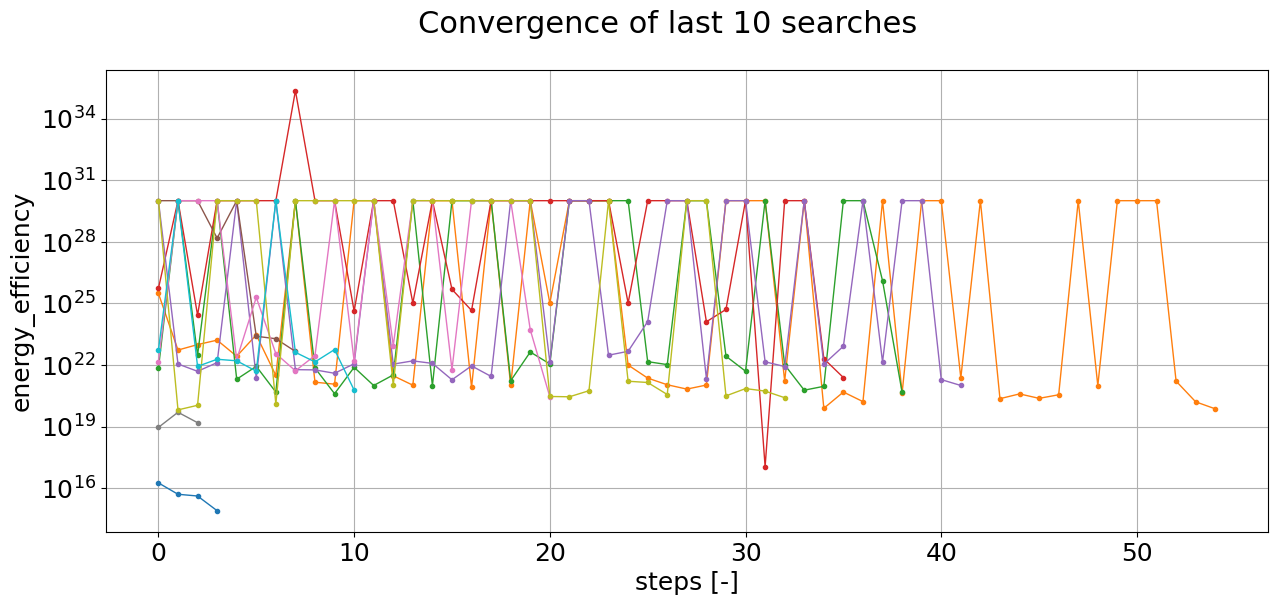

In [48]:
"""Plot convergence of last searches"""

if len(to_plot) > 10:
    to_plot2 = to_plot[-10:]
else:
    to_plot2 = to_plot

fig, ax = plt.subplots(1, 1, figsize=(15, 6))
fig.suptitle('Convergence of last 10 searches', fontsize=22)
ax.set_ylabel(f'{to_optimize}')
#ax.set_ylim(0.95*best_output, 1.5*best_output)
ax.set_yscale('log')
ax.set_xlabel('steps [-]')
ax.grid()
for plot in to_plot2:
    ax.plot(plot, '.-', linewidth=1.0)
plt.show()

ValueError: 35689062.38881727 is not in list

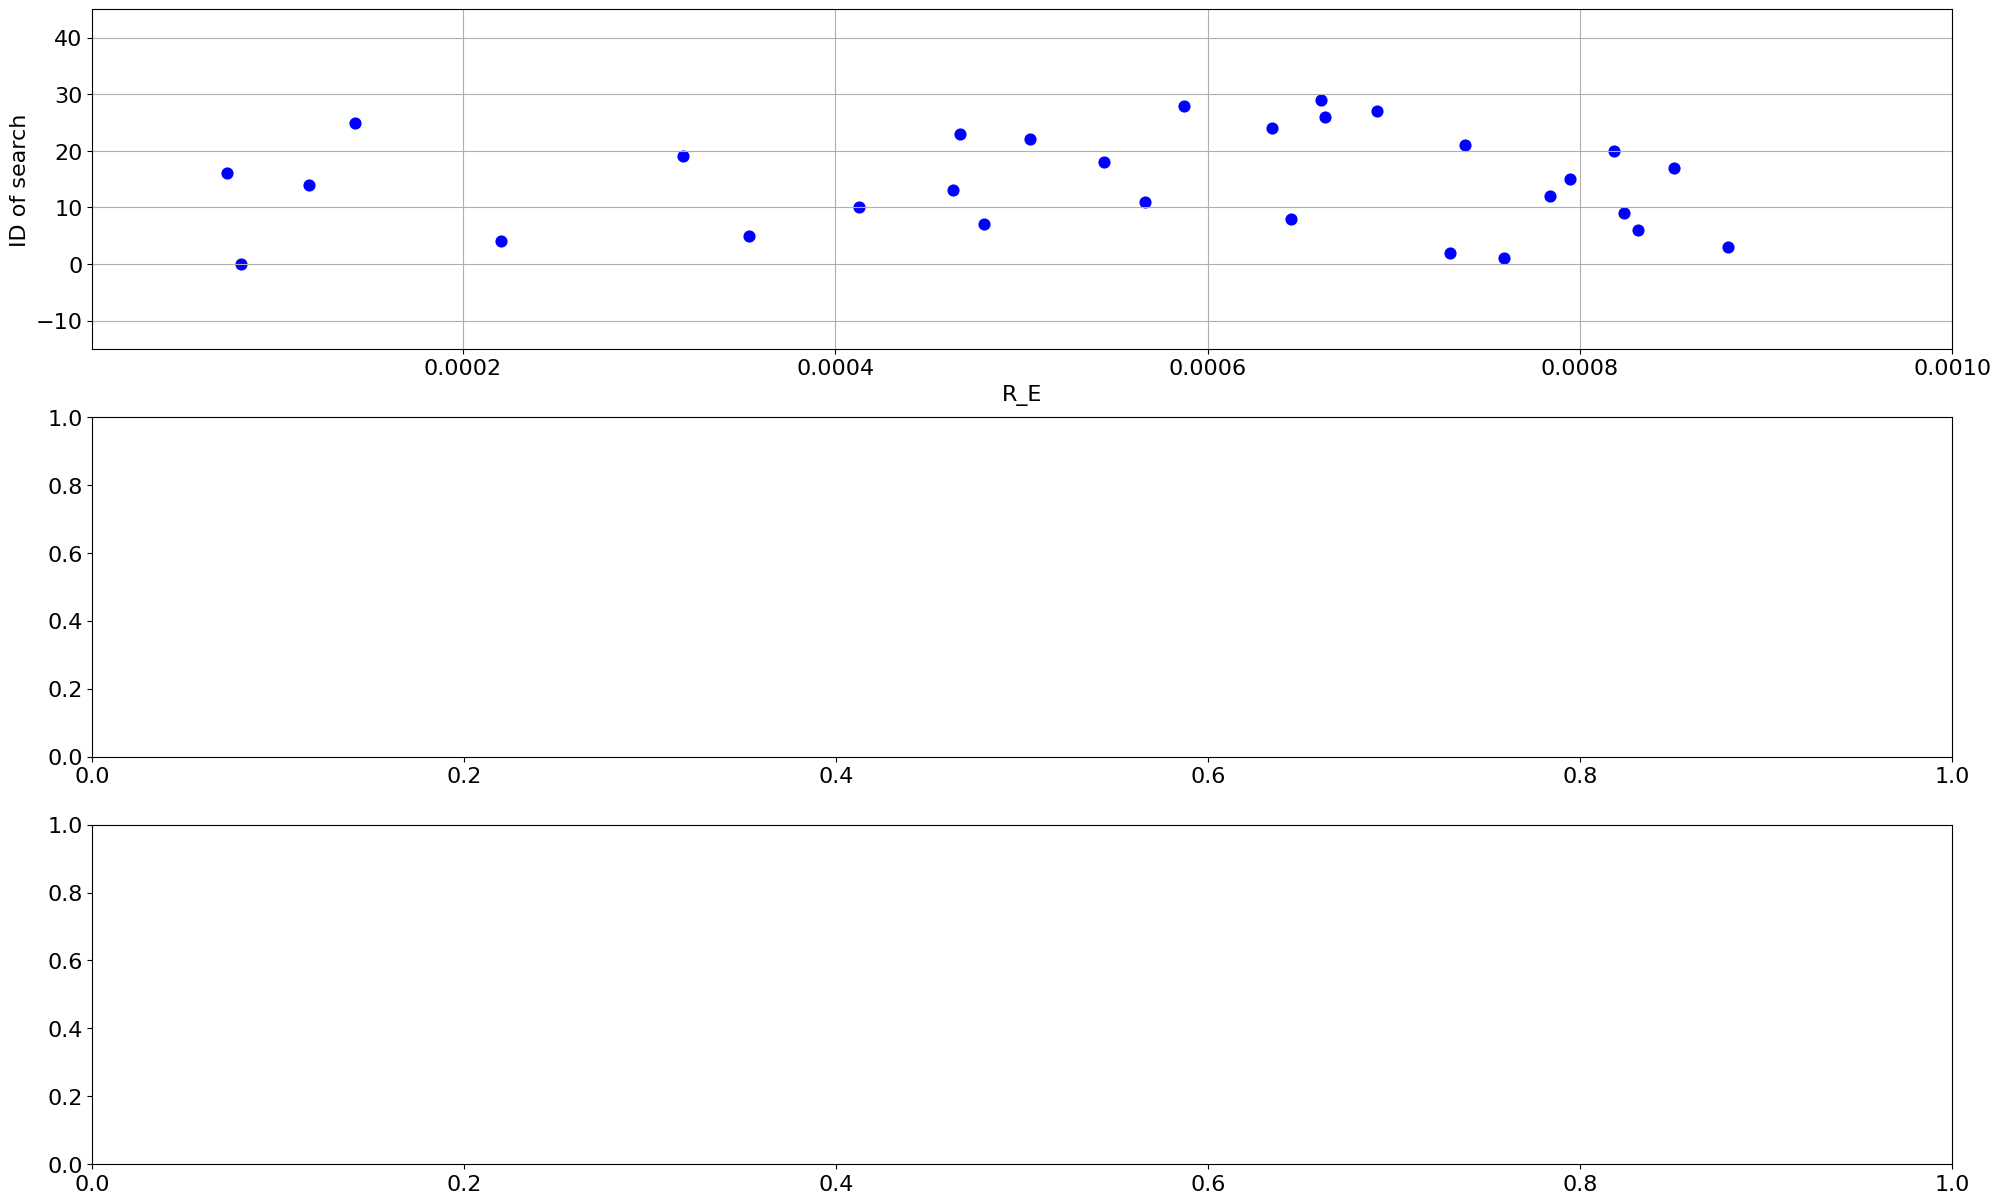

In [49]:
"""Plot the distribution of the optimums"""

plt.rcParams.update({'font.size': 16})
ranges2 = dict()
for key in ranges:
    if len(ranges[key]) > 1:
        ranges2[key] = ranges[key]

n = len(ranges2)
fig, ax = plt.subplots(n, 1, figsize=(24, 5*n))
for i, key in enumerate(ranges2):
    last_values = [last_point[key] for last_point in last_points]
    y = [i for i, last_point in enumerate(last_points)]
        
  # ploting:
    ax[i].scatter(last_values, y, s=60, color='b')
    ax[i].set_ylabel('ID of search')
    ax[i].set_xlabel(key)
    ax[i].set_xlim(ranges2[key])
    n = len(last_points)
    ax[i].set_ylim([-0.5*n, 1.5*n])
    ax[i].grid()
    # best point:
    index = [x[-1] for x in to_plot].index(best_output)
    best_point = last_points[index]
    ax[i].scatter([best_point[key]], [0.5*n], s=200, color='r')
